# CERN Project $H$ --> $\mu \mu$ - version 5

## Dataframe creation

### Imports Python libraries

In [1]:
import ROOT
import uproot
import awkward as ak
import cmsstyle as CMS
import numpy as np
import pandas as pd
import os
import math
import importlib
import matplotlib.pyplot as plt
import mplhep as hep
import itertools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import tables
from func import *

### Creates the dataset

In [2]:
hep.style.use("CMS")

# input file with signal
input_file_sig = "/mnt/c/users/chiar/Desktop/ProgettoCERN/Dati_CERN/Segnale/06bbd185-e71f-4ee4-95e1-8cb50efd1e51.root"

# input file with Drell-Yan background
input_file_bkg = "/mnt/c/users/chiar/Desktop/ProgettoCERN/Dati_CERN/Fondo/03a47683-caaa-4bd7-98b8-585e9f23f9ec.root"

# creates a ROOT dataframe 
dataframe_sig = ROOT.RDataFrame("Events", input_file_sig)
dataframe_bkg = ROOT.RDataFrame("Events", input_file_bkg)

In [3]:
ROOT.gInterpreter.Declare("""
    #include <cmath>

    double EvaluateDeltaPhi(double phi1, double phi2) {
        double deltaPhi = std::fabs(phi1 - phi2);
        if (deltaPhi > TMath::Pi()) {
            deltaPhi = 2*TMath::Pi()-deltaPhi;
        }
        return deltaPhi;
    }
""")

True

In [4]:
# applies filters to the signal dataset
df_twomuons_sig = (
    dataframe_sig.Filter("HLT_IsoMu24 == true", "HLT_IsoMu24 cut")
    .Filter("All(Muon_tightId == true)", "tightId cut")
    .Filter("All(Muon_pfIsoId >=4)", "pfIsoId tight cut")
    .Filter("All(Muon_eta < 2.4) && All (Muon_eta > -2.4)", "Eta cut 2.4")
     #.Filter("All(Jet_btagPNetB < 0.6)", "btag cut")
    .Filter("nMuon >= 2", "two or more muons")
    .Filter("Any(Muon_charge == 1) && Any(Muon_charge == -1)", "2 muons with opposite charge")
    .Filter("Muon_pt[0] > 25", "Muon1_pt > 25")
)

# applies to the background dataset the same cuts applied in the High Level Trigger in the signal dataset
df_twomuons_bkg = (
    dataframe_bkg.Filter("HLT_IsoMu24 == true", "HLT_IsoMu24 cut")
    .Filter("All(Muon_tightId == true)", "tightId cut")
    .Filter("All(Muon_pfIsoId >=4)", "pfIsoId tight cut")
    .Filter("All(Muon_eta < 2.4) && All (Muon_eta > -2.4)", "Eta cut 2.4")
     #.Filter("All(Jet_btagPNetB < 0.6)", "btag cut")
    .Filter("nMuon >= 2", "two or more muons")
    .Filter("Any(Muon_charge == 1) && Any(Muon_charge == -1)", "2 muons with opposite charge")
    .Filter("Muon_pt[0] > 25", "Muon1_pt > 25")
)

In [5]:
# finds the first couple of muons with opposite charge
ROOT.gInterpreter.Declare("""
std::pair<int,int> FindOppositeChargePair(const ROOT::VecOps::RVec<float> &pt,
                                          const ROOT::VecOps::RVec<int> &charge) {
    // Lista di indici ordinati per pT decrescente
    std::vector<int> idx(pt.size());
    std::iota(idx.begin(), idx.end(), 0);
    std::sort(idx.begin(), idx.end(), [&](int i, int j){ return pt[i] > pt[j]; });

    // Cerca la prima coppia a carica opposta nell'ordine di pT
    for (size_t i = 0; i < idx.size(); ++i) {
        for (size_t j = i+1; j < idx.size(); ++j) {
            if (charge[idx[i]] * charge[idx[j]] == -1) {
                return { idx[i], idx[j] }; // Leading, subleading
            }
        }
    }
    return { -1, -1 }; // Nessuna coppia trovata
}
""")

True

In [6]:
df_twomuons_sig = (
    # Trova coppia (leading/subleading in pT)
    df_twomuons_sig.Define("opp_pair", "FindOppositeChargePair(Muon_pt, Muon_charge)")

    # Indici separati
    .Define("idx_mu1", "opp_pair.first")
    .Define("idx_mu2", "opp_pair.second")

    # Filtra solo eventi dove coppia esiste
    .Filter("idx_mu1 >= 0 && idx_mu2 >= 0", "Opposite charge pair found")

    # adds to the dataframe columns containing the leading muon variables
    .Define("Muon1_pt", "Muon_pt[idx_mu1]")
    .Define("Muon1_bsConstrainedPt", "Muon_bsConstrainedPt[idx_mu1]")
    .Define("Muon1_eta", "Muon_eta[idx_mu1]")
    .Define("Muon1_phi", "Muon_phi[idx_mu1]")
    .Define("Muon1_mass", "Muon_mass[idx_mu1]")
    .Define("Muon1_charge", "Muon_charge[idx_mu1]")

    # adds to the dataframe columns containing the subleading muon variables
    .Define("Muon2_pt", "Muon_pt[idx_mu2]")
    .Define("Muon2_bsConstrainedPt", "Muon_bsConstrainedPt[idx_mu2]")
    .Define("Muon2_eta", "Muon_eta[idx_mu2]")
    .Define("Muon2_phi", "Muon_phi[idx_mu2]")
    .Define("Muon2_charge", "Muon_charge[idx_mu2]")
    .Define("Muon2_mass", "Muon_mass[idx_mu2]")

    # adds to the dataframe the differences in pt, eta, phi and R
    .Define("Muon_DeltaPt", "Muon1_pt - Muon2_pt")
    .Define("Muon_DeltaPhi", "EvaluateDeltaPhi(Muon1_phi, Muon2_phi)")
    .Define("Muon_DeltaEta", "abs(Muon1_eta - Muon2_eta)")
    .Define("Muon_DeltaR", "sqrt(pow(Muon_DeltaEta, 2) + pow(Muon_DeltaPhi, 2))")
    
    # adds to the dataframe the differences in charge between the two muons and the difference between the 
    # two pt of the muons normalized to the pt of the leading muon
    .Define("Muon_DeltaPt_norm", "Muon_DeltaPt/Muon1_pt")
    .Define("Muon_DeltaCharge", "Muon1_charge - Muon2_charge")

    # adds to the dataframe the variables related to the dimuon system
    .Define("Dimuon_LV", "sum_TLorentzVector(Muon1_pt, Muon1_eta, Muon1_phi, Muon1_mass, Muon2_pt, Muon2_eta, Muon2_phi, Muon2_mass)")
    .Define("Dimuon_pt", "Dimuon_LV.Pt()")
    .Define("Dimuon_eta", "Dimuon_LV.Eta()")
    .Define("Dimuon_phi", "Dimuon_LV.Phi()")
    .Define("Dimuon_mass", "Dimuon_LV.M()")
    .Define("Muon1_Pt_norm", "Muon1_pt/Dimuon_mass")
    .Define("Muon2_Pt_norm", "Muon2_pt/Dimuon_mass")

    # adds to the dataframe the variable d_xy
    .Define("Muon1_dxy", "Muon_dxy[idx_mu1]")
    .Define("Muon2_dxy", "Muon_dxy[idx_mu2]")
)

# Controllo visivo di qualche evento
df_twomuons_sig.Display(["Muon1_pt", "Muon2_pt", "Muon1_charge", "Muon2_charge"]).Print()

+-----+------------+-----------+--------------+--------------+
| Row | Muon1_pt   | Muon2_pt  | Muon1_charge | Muon2_charge | 
+-----+------------+-----------+--------------+--------------+
| 0   | 71.231140  | 46.701633 | -1           | 1            | 
+-----+------------+-----------+--------------+--------------+
| 2   | 59.076302  | 58.157383 | -1           | 1            | 
+-----+------------+-----------+--------------+--------------+
| 7   | 36.792263  | 28.792959 | 1            | -1           | 
+-----+------------+-----------+--------------+--------------+
| 9   | 124.584595 | 32.391800 | 1            | -1           | 
+-----+------------+-----------+--------------+--------------+
| 16  | 63.861507  | 55.249695 | -1           | 1            | 
+-----+------------+-----------+--------------+--------------+


In [7]:
df_twomuons_bkg = (
    # Trova coppia (leading/subleading in pT)
    df_twomuons_bkg.Define("opp_pair", "FindOppositeChargePair(Muon_pt, Muon_charge)")

    # Indici separati
    .Define("idx_mu1", "opp_pair.first")
    .Define("idx_mu2", "opp_pair.second")

    # Filtra solo eventi dove coppia esiste
    .Filter("idx_mu1 >= 0 && idx_mu2 >= 0", "Opposite charge pair found")

    # adds to the dataframe columns containing the leading muon variables
    .Define("Muon1_pt", "Muon_pt[idx_mu1]")
    .Define("Muon1_bsConstrainedPt", "Muon_bsConstrainedPt[idx_mu1]")
    .Define("Muon1_eta", "Muon_eta[idx_mu1]")
    .Define("Muon1_phi", "Muon_phi[idx_mu1]")
    .Define("Muon1_mass", "Muon_mass[idx_mu1]")
    .Define("Muon1_charge", "Muon_charge[idx_mu1]")

    # adds to the dataframe columns containing the subleading muon variables
    .Define("Muon2_pt", "Muon_pt[idx_mu2]")
    .Define("Muon2_bsConstrainedPt", "Muon_bsConstrainedPt[idx_mu2]")
    .Define("Muon2_eta", "Muon_eta[idx_mu2]")
    .Define("Muon2_phi", "Muon_phi[idx_mu2]")
    .Define("Muon2_charge", "Muon_charge[idx_mu2]")
    .Define("Muon2_mass", "Muon_mass[idx_mu2]")

    # adds to the dataframe the differences in pt, eta, phi and R
    .Define("Muon_DeltaPt", "Muon1_pt - Muon2_pt")
    .Define("Muon_DeltaPhi", "EvaluateDeltaPhi(Muon1_phi, Muon2_phi)")
    .Define("Muon_DeltaEta", "abs(Muon1_eta - Muon2_eta)")
    .Define("Muon_DeltaR", "sqrt(pow(Muon_DeltaEta, 2) + pow(Muon_DeltaPhi, 2))")
    
    # adds to the dataframe the differences in charge between the two muons and the difference between the 
    # two pts of the muons normalized to the pt of the leading muon
    .Define("Muon_DeltaPt_norm", "Muon_DeltaPt/Muon1_pt")
    .Define("Muon_DeltaCharge", "Muon1_charge - Muon2_charge")

    # adds to the dataframe the variables related to the dimuon system
    .Define("Dimuon_LV", "sum_TLorentzVector(Muon1_pt, Muon1_eta, Muon1_phi, Muon1_mass, Muon2_pt, Muon2_eta, Muon2_phi, Muon2_mass)")
    .Define("Dimuon_pt", "Dimuon_LV.Pt()")
    .Define("Dimuon_eta", "Dimuon_LV.Eta()")
    .Define("Dimuon_phi", "Dimuon_LV.Phi()")
    .Define("Dimuon_mass", "Dimuon_LV.M()")
    .Define("Muon1_Pt_norm", "Muon1_pt/Dimuon_mass")
    .Define("Muon2_Pt_norm", "Muon2_pt/Dimuon_mass")

    # adds to the dataframe the variable d_xy
    .Define("Muon1_dxy", "Muon_dxy[idx_mu1]")
    .Define("Muon2_dxy", "Muon_dxy[idx_mu2]")
)

# Controllo visivo di qualche evento
df_twomuons_sig.Display(["Muon1_pt", "Muon2_pt", "Muon1_charge", "Muon2_charge"]).Print()

+-----+------------+-----------+--------------+--------------+
| Row | Muon1_pt   | Muon2_pt  | Muon1_charge | Muon2_charge | 
+-----+------------+-----------+--------------+--------------+
| 0   | 71.231140  | 46.701633 | -1           | 1            | 
+-----+------------+-----------+--------------+--------------+
| 2   | 59.076302  | 58.157383 | -1           | 1            | 
+-----+------------+-----------+--------------+--------------+
| 7   | 36.792263  | 28.792959 | 1            | -1           | 
+-----+------------+-----------+--------------+--------------+
| 9   | 124.584595 | 32.391800 | 1            | -1           | 
+-----+------------+-----------+--------------+--------------+
| 16  | 63.861507  | 55.249695 | -1           | 1            | 
+-----+------------+-----------+--------------+--------------+


In [8]:
print("Columns available in the ROOT DataFrame with their type:")
for col in df_twomuons_sig.GetColumnNames():
    ctype = df_twomuons_sig.GetColumnType(col)
    print(f"{col} : {ctype}")

Columns available in the ROOT DataFrame with their type:
BeamSpot_sigmaZ : Float_t
BeamSpot_sigmaZError : Float_t
BeamSpot_type : Char_t
BeamSpot_z : Float_t
BeamSpot_zError : Float_t
CaloMET_phi : Float_t
CaloMET_pt : Float_t
CaloMET_sumEt : Float_t
ChsMET_phi : Float_t
ChsMET_pt : Float_t
ChsMET_sumEt : Float_t
CleanJet_PNetRegPtRawCorr : ROOT::VecOps::RVec<float>
CleanJet_PNetRegPtRawCorrNeutrino : ROOT::VecOps::RVec<float>
CleanJet_PNetRegPtRawRes : ROOT::VecOps::RVec<float>
CleanJet_area : ROOT::VecOps::RVec<float>
CleanJet_btagDeepFlavB : ROOT::VecOps::RVec<float>
CleanJet_btagDeepFlavCvB : ROOT::VecOps::RVec<float>
CleanJet_btagDeepFlavCvL : ROOT::VecOps::RVec<float>
CleanJet_btagDeepFlavQG : ROOT::VecOps::RVec<float>
CleanJet_btagPNetB : ROOT::VecOps::RVec<float>
CleanJet_btagPNetCvB : ROOT::VecOps::RVec<float>
CleanJet_btagPNetCvL : ROOT::VecOps::RVec<float>
CleanJet_btagPNetQvG : ROOT::VecOps::RVec<float>
CleanJet_btagPNetTauVJet : ROOT::VecOps::RVec<float>
CleanJet_btagRobus

### Study of the distance from the primary vertex to reduce b-quark background

In [9]:
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon1_dxy", "Muon2_dxy", 40, -0.001, 0.007, 40, 0, 0.007, "d_{xy} [cm]", "Events", "Leading #mu", "Subleading #mu")
plot2Histo1D_df(df_twomuons_bkg, df_twomuons_bkg, "Muon1_dxy", "Muon2_dxy", 40, -0.001, 0.007, 40, 0, 0.007, "d_{xy} [cm]", "Events", "Leading #mu", "Subleading #mu")

## Signal 

### General features of signal data

In [10]:
plotHisto1D_df(dataframe_sig, "nMuon", 8, -0.5, 7.5, "Number of muons", "Events")
plotHisto1D_df(dataframe_sig, "nJet", 13, -0.5, 12.5, "Number of jets", "Events")
plotHisto1D_df(dataframe_sig, "nPhoton", 5, -0.5, 4.5, "Number of photons", "Events")

### Plots with two muons

In [11]:
# plots the histogram of pt for the two muons
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon1_pt", "Muon2_pt", 40, 0, 300, 40, 0, 300, "p_{T} [GeV]", "Events", "Leading #mu", "Subleading #mu")
plotHisto1D_df(df_twomuons_sig, "Muon_DeltaPt", 40, 0, 250, "#Deltap_{T} [GeV]", "Events")

In [12]:
# plots the histogram of phi for the two muons
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon1_phi", "Muon2_phi", 30, -math.pi, math.pi, 30, -math.pi, math.pi, "#phi [rad]", "Events", "Muon1_phi", "Muon2_phi")
plotHisto1D_df(df_twomuons_sig, "Muon_DeltaPhi", 30, 0, math.pi, "#Delta#phi [rad]", "Events")

# plots the histogram of eta for the two muons
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon1_eta", "Muon2_eta", 30, -2.4, 2.4, 30, -2.4, 2.4, "#eta", "Events", "Muon1_eta", "Muon2_eta")
plotHisto1D_df(df_twomuons_sig, "Muon_DeltaEta", 30, 0, 5, "#Delta#eta", "Events")

# plots the histogram of the DeltaR
plotHisto1D_df(df_twomuons_sig, "Muon_DeltaR", 40, 0, 5, "#DeltaR", "Events")

# plots the histogram of the charge of the two muons
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon1_charge", "Muon2_charge", 13, -1.3, 1.3, 13, -1.3, 1.3, "Charge", "Events", "Muon1_charge", "Muon2_charge")
plotHisto1D_df(df_twomuons_sig, "Muon_DeltaCharge", 23, -2.3, 2.3, "#Deltaq", "Events")

# plots the histogram of the mass of the two muons
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon1_mass", "Muon2_mass", 7, 0.04, 0.16, 7, 0.04, 0.16, "m_{#mu} [GeV]", "Events", "Muon1_mass", "Muon2_mass")

In [13]:
# shows the difference of pts between the two muons normalized to the pt of the first muon
plotHisto1D_df(df_twomuons_sig, "Muon_DeltaPt_norm", 40, 0, 1, "#Deltap_{T} [GeV]", "Events")

# shows the pts of the two muons normalized to the invariant mass of the system
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon1_Pt_norm", "Muon2_Pt_norm", 40, 0, 2, 40, 0, 2, "p_{T}/m^{#mu#mu}", "Events", "Leading #mu", "Subleading #mu")

In [14]:
# density plot for relevant features of the two muons
plotHisto2D_df(df_twomuons_sig, "Muon1_pt", "Muon2_pt", 60, 0, 300, 60, 0, 300, "p_{T}(#mu_{L}) [GeV]", "p_{T}(#mu_{Sl}) [GeV]", "Number of events")
plotHisto2D_df(df_twomuons_sig, "Muon1_eta", "Muon2_eta", 40, -2.4, 2.4, 40, -2.4, 2.4, "#eta(#mu_{L})", "#eta(#mu_{Sl})", "Number of events")
plotHisto2D_df(df_twomuons_sig, "Muon1_phi", "Muon2_phi", 50, -math.pi, math.pi, 50, -math.pi, math.pi, "#phi(#mu_{L})", "#phi(#mu_{Sl})", "Number of events")

In [15]:
plotHisto2D_df(df_twomuons_sig, "Muon_DeltaEta", "Muon_DeltaPhi", 60, 0, 4, 60, 0, math.pi, "#Delta#eta", "#Delta#phi [rad]", "Number of events")
plotHisto2D_df(df_twomuons_sig, "Muon_DeltaPt", "Muon_DeltaPhi", 50, 0, 250, 50, 0, math.pi, "#Deltap_{T} [GeV]", "#Delta#phi [rad]", "Number of events")
plotHisto2D_df(df_twomuons_sig, "Muon_DeltaPt", "Muon_DeltaEta", 50, 0, 250, 50, 0, 4, "#Deltap_{T} [GeV]", "#Delta#eta", "Number of events")

In [16]:
plotHisto2D_df(df_twomuons_sig, "Muon_DeltaR", "Muon_DeltaPhi", 50, 0, 5, 50, 0, math.pi, "#DeltaR", "#Delta#phi [rad]", "Number of events")
plotHisto2D_df(df_twomuons_sig, "Muon_DeltaR", "Muon_DeltaEta", 50, 0, 5, 50, 0, 4, "#DeltaR", "#Delta#eta", "Number of events")
plotHisto2D_df(df_twomuons_sig, "Muon_DeltaR", "Muon_DeltaPt", 50, 0, 5, 50, 0, 250, "#DeltaR", "#Deltap_{T} [GeV]", "Number of events")

### Dimuon system

In [17]:
plotHisto1D_df(df_twomuons_sig, "Dimuon_pt", 40, 0, 300, "p_{T}^{#mu#mu} [GeV]", "Events")
plotHisto1D_df(df_twomuons_sig, "Dimuon_eta", 40, -5, 5, "#eta^{#mu#mu}", "Events")
plotHisto1D_df(df_twomuons_sig, "Dimuon_phi", 40, -math.pi, math.pi, "#phi^{#mu#mu} [rad]", "Events")
plotHisto1D_df(df_twomuons_sig, "Dimuon_mass", 60, 0, 200, "m^{#mu#mu} [GeV]", "Events")
plotHisto1D_df(df_twomuons_sig, "Dimuon_mass", 40, 100, 150, "m^{#mu#mu} [GeV]", "Events")

## Background

### Plots of the background features

In [18]:
plot2Histo1D_df(df_twomuons_bkg, df_twomuons_bkg, "Muon1_pt", "Muon2_pt", 40, 0, 300, 40, 0, 300, "p_{T} [GeV]", "Events", "Leading #mu", "Subleading #mu")
plotHisto1D_df(df_twomuons_bkg, "Muon_DeltaPt", 40, 0, 250, "#Deltap_{T} [GeV]", "Events")

In [19]:
# plots the histogram of phi for the two muons
plot2Histo1D_df(df_twomuons_bkg, df_twomuons_bkg, "Muon1_phi", "Muon2_phi", 30, -math.pi, math.pi, 30, -math.pi, math.pi, "#phi [rad]", "Events", "Muon1_phi", "Muon2_phi")
plotHisto1D_df(df_twomuons_bkg, "Muon_DeltaPhi", 30, 0, math.pi, "#Delta#phi [rad]", "Events")

# plots the histogram of eta for the two muons
plot2Histo1D_df(df_twomuons_bkg, df_twomuons_bkg, "Muon1_eta", "Muon2_eta", 30, -2.4, 2.4, 30, -2.4, 2.4, "#eta", "Events", "Muon1_eta", "Muon2_eta")
plotHisto1D_df(df_twomuons_bkg, "Muon_DeltaEta", 30, 0, 5, "#Delta#eta", "Events")

# plots the histogram of the DeltaR
plotHisto1D_df(df_twomuons_bkg, "Muon_DeltaR", 40, 0, 5, "#DeltaR", "Events")

# plots the histogram of the charge of the two muons
plot2Histo1D_df(df_twomuons_bkg, df_twomuons_bkg, "Muon1_charge", "Muon2_charge", 13, -1.3, 1.3, 13, -1.3, 1.3, "Charge", "Events", "Muon1_charge", "Muon2_charge")
plotHisto1D_df(df_twomuons_bkg, "Muon_DeltaCharge", 23, -2.3, 2.3, "#Deltaq", "Events")

# plots the histogram of the mass of the two muons
plot2Histo1D_df(df_twomuons_bkg, df_twomuons_bkg, "Muon1_mass", "Muon2_mass", 7, 0.04, 0.16, 7, 0.04, 0.16, "m_{#mu} [GeV]", "Events", "Muon1_mass", "Muon2_mass")

In [20]:
# shows the difference of pts between the two muons normalized to the pt of the first muon
plotHisto1D_df(df_twomuons_bkg, "Muon_DeltaPt_norm", 40, 0, 1, "#Deltap_{T} [GeV]", "Events")

# shows the pts of the two muons normalized to the invariant mass of the system
plot2Histo1D_df(df_twomuons_bkg, df_twomuons_bkg, "Muon1_Pt_norm", "Muon2_Pt_norm", 40, 0, 2, 40, 0, 2, "p_{T}/m^{#mu#mu}", "Events", "Leading #mu", "Subleading #mu")

In [21]:
# density plot for relevant features of the two muons
plotHisto2D_df(df_twomuons_bkg, "Muon1_pt", "Muon2_pt", 60, 0, 300, 60, 0, 300, "p_{T}(#mu_{L}) [GeV]", "p_{T}(#mu_{Sl}) [GeV]", "Number of events")
plotHisto2D_df(df_twomuons_bkg, "Muon1_eta", "Muon2_eta", 40, -2.4, 2.4, 40, -2.4, 2.4, "#eta(#mu_{L})", "#eta(#mu_{Sl})", "Number of events")
plotHisto2D_df(df_twomuons_bkg, "Muon1_phi", "Muon2_phi", 50, -math.pi, math.pi, 50, -math.pi, math.pi, "#phi(#mu_{L})", "#phi(#mu_{Sl})", "Number of events")

In [22]:
plotHisto2D_df(df_twomuons_bkg, "Muon_DeltaEta", "Muon_DeltaPhi", 60, 0, 4, 60, 0, math.pi, "#Delta#eta", "#Delta#phi [rad]", "Number of events")
plotHisto2D_df(df_twomuons_bkg, "Muon_DeltaPt", "Muon_DeltaPhi", 50, 0, 250, 50, 0, math.pi, "#Deltap_{T} [GeV]", "#Delta#phi [rad]", "Number of events")
plotHisto2D_df(df_twomuons_bkg, "Muon_DeltaPt", "Muon_DeltaEta", 50, 0, 250, 50, 0, 4, "#Deltap_{T} [GeV]", "#Delta#eta", "Number of events")

In [23]:
plotHisto2D_df(df_twomuons_bkg, "Muon_DeltaR", "Muon_DeltaPhi", 50, 0, 5, 50, 0, math.pi, "#DeltaR", "#Delta#phi [rad]", "Number of events")
plotHisto2D_df(df_twomuons_bkg, "Muon_DeltaR", "Muon_DeltaEta", 50, 0, 5, 50, 0, 4, "#DeltaR", "#Delta#eta", "Number of events")
plotHisto2D_df(df_twomuons_bkg, "Muon_DeltaR", "Muon_DeltaPt", 50, 0, 5, 50, 0, 250, "#DeltaR", "#Deltap_{T} [GeV]", "Number of events")

### Dimuon system

In [24]:
plotHisto1D_df(df_twomuons_bkg, "Dimuon_pt", 40, 0, 300, "p_{T}^{#mu#mu} [GeV]", "Events")
plotHisto1D_df(df_twomuons_bkg, "Dimuon_eta", 40, -5, 5, "#eta^{#mu#mu}", "Events")
plotHisto1D_df(df_twomuons_bkg, "Dimuon_phi", 40, -math.pi, math.pi, "#phi^{#mu#mu} [rad]", "Events")
plotHisto1D_df(df_twomuons_bkg, "Dimuon_mass", 60, 0, 200, "m^{#mu#mu} [GeV]", "Events")
plotHisto1D_df(df_twomuons_bkg, "Dimuon_mass", 40, 80, 150, "m^{#mu#mu} [GeV]", "Events")

## Comparison between signal and background

### Dimuon system

In [25]:
#comparison between signal and background in arbitrary units to compare the form of the distributions
plot2Histo1D_df(df_twomuons_sig, df_twomuons_bkg, "Dimuon_pt", "Dimuon_pt", 40, 0, 300, 40, 0, 300, "p_{T}^{#mu#mu} [GeV]", "A.U.", "Signal", "Background", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_twomuons_bkg, "Dimuon_eta", "Dimuon_eta", 40, -5, 5, 40, -5, 5, "#eta^{#mu#mu}", "A.U.", "Signal", "Background", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_twomuons_bkg, "Dimuon_phi", "Dimuon_phi", 40, -math.pi, math.pi, 40, -math.pi, math.pi, "#phi^{#mu#mu} [rad]", "A.U.", "Signal", "Background", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_twomuons_bkg, "Dimuon_mass", "Dimuon_mass", 40, 80, 150, 40, 80, 150, "m^{#mu#mu} [GeV]", "A.U.", "Signal", "Background", norm = True)

## Jets

### Selection of VBF jets using the particle generator

In [26]:
# display idx, pdgId, motherId per un evento
file = uproot.open(input_file_sig)
events = file["Events"]
GenPart_pdgId = events["GenPart_pdgId"].array()
GenPart_genPartIdxMother = events["GenPart_genPartIdxMother"].array()
GenPart_status = events["GenPart_status"].array()
GenPart_eta = events["GenPart_eta"].array()

event = 98
Muon_pt = []
Muon_eta = []
Muon_phi = []
print("Index\t |\t pdgId\t |\t mother\t\t |\t status \t|\t eta\n")
for i, pid in enumerate(GenPart_pdgId[event]):
    mother_idx = GenPart_genPartIdxMother[event][i]
    status = GenPart_status[event][i]
    eta = GenPart_eta[event][i]
    if mother_idx >= 0:
        mother_pdgId = GenPart_pdgId[event][mother_idx]
        print(f"{i}\t |\t {pid}\t | (index={mother_idx}, pdgId={mother_pdgId})\t |\t {status} \t|\t {eta}")
    else:
        print(f"{i}\t |\t {pid}\t |\t -1 \t\t |\t {status} \t|\t {eta}")

Index	 |	 pdgId	 |	 mother		 |	 status 	|	 eta

0	 |	 21	 |	 -1 		 |	 21 	|	 22976.0
1	 |	 2	 |	 -1 		 |	 21 	|	 -22976.0
2	 |	 25	 | (index=0, pdgId=21)	 |	 22 	|	 -1.375
3	 |	 -1	 | (index=0, pdgId=21)	 |	 23 	|	 2.390625
4	 |	 1	 | (index=0, pdgId=21)	 |	 23 	|	 -1.5078125
5	 |	 2	 | (index=0, pdgId=21)	 |	 23 	|	 3.2265625
6	 |	 -4	 | (index=7, pdgId=-4)	 |	 31 	|	 22784.0
7	 |	 -4	 |	 -1 		 |	 41 	|	 39.0
8	 |	 25	 | (index=2, pdgId=25)	 |	 44 	|	 -1.375
9	 |	 25	 | (index=8, pdgId=25)	 |	 44 	|	 -1.375
10	 |	 25	 | (index=9, pdgId=25)	 |	 44 	|	 -1.375
11	 |	 25	 | (index=10, pdgId=25)	 |	 62 	|	 -1.3828125
12	 |	 13	 | (index=11, pdgId=25)	 |	 23 	|	 -0.75
13	 |	 -13	 | (index=11, pdgId=25)	 |	 23 	|	 -0.50390625
14	 |	 13	 | (index=12, pdgId=13)	 |	 1 	|	 -0.75
15	 |	 22	 | (index=12, pdgId=13)	 |	 1 	|	 -0.7109375
16	 |	 -13	 | (index=13, pdgId=-13)	 |	 1 	|	 -0.50390625
17	 |	 -1	 | (index=3, pdgId=-1)	 |	 71 	|	 2.34375
18	 |	 2	 | (index=5, pdgId=2)	 |	 71 	|	 3.0703125
19	

In [27]:
ROOT.gInterpreter.Declare("""
std::vector<int> findAssociatedParticlesWithMotherIndexZero(
    const ROOT::VecOps::RVec<int>& pdgId,
    const ROOT::VecOps::RVec<int>& motherIdx,
    const ROOT::VecOps::RVec<float>& eta,
    const ROOT::VecOps::RVec<float>& pt
) {
    // 1. Cerca l'Higgs con madre all'indice 0.
    bool higgs_found = false;
    for (size_t i = 0; i < pdgId.size(); ++i) {
        if (pdgId[i] == 25 && motherIdx[i] == 0) {
            higgs_found = true;
            break;
        }
    }

    if (!higgs_found) {
        return {}; // Se l'Higgs non ha madre all'indice 0, restituisci un array vuoto.
    }

    // 2. Cerca i quark candidati che hanno la stessa madre all'indice 0.
    std::vector<int> candidates;
    for (size_t i = 0; i < pdgId.size(); ++i) {
        // La condizione è che sia un quark (PdgId 1-6) e che abbia madre all'indice 0.
        if (std::abs(pdgId[i]) >= 1 && std::abs(pdgId[i]) <= 6 && motherIdx[i] == 0) {
            candidates.push_back(i);
        }
    }

    // Se non ci sono almeno due quark candidati, restituisci un array vuoto.
    if (candidates.size() < 2) {
        return {};
    }

    // 3. Trova la coppia di quark con il massimo DeltaEta.
    int max_idx1 = -1, max_idx2 = -1;
    float max_deta = -1.0;

    for (size_t i = 0; i < candidates.size(); ++i) {
        for (size_t j = i + 1; j < candidates.size(); ++j) {
            float deta = std::abs(eta[candidates[i]] - eta[candidates[j]]);
            if (deta > max_deta) {
                max_deta = deta;
                max_idx1 = candidates[i];
                max_idx2 = candidates[j];
            }
        }
    }

    // Restituisce gli indici dei due quark trovati.
    if (max_idx1 != -1 && max_idx2 != -1) {
        // Aggiunta la logica di ordinamento per pT
        if (pt[max_idx1] > pt[max_idx2]) {
            return {max_idx1, max_idx2};
        } else {
            return {max_idx2, max_idx1};
        }
    }

    return {};
}
""")

True

In [28]:
df_twomuons_sig = (
    df_twomuons_sig.Define("vbf_quark_indices", "findAssociatedParticlesWithMotherIndexZero(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_eta, GenPart_pt)")
    .Filter("vbf_quark_indices.size() == 2", "VBF Higgs event found")
    .Define("vbf_q1_idx", "vbf_quark_indices[0]")
    .Define("vbf_q2_idx", "vbf_quark_indices[1]")
    
    .Define("q1_pt", "GenPart_pt[vbf_q1_idx]")
    .Define("q1_eta", "GenPart_eta[vbf_q1_idx]")
    .Define("q1_phi", "GenPart_phi[vbf_q1_idx]")
    .Define("q1_mass", "GenPart_mass[vbf_q1_idx]")
    .Define("q2_pt", "GenPart_pt[vbf_q2_idx]")
    .Define("q2_eta", "GenPart_eta[vbf_q2_idx]")
    .Define("q2_phi", "GenPart_phi[vbf_q2_idx]")
    .Define("q2_mass", "GenPart_mass[vbf_q2_idx]")

    #adds to the dataframe the differences in pt, eta, phi and R
    .Define("q_DeltaPt", "q1_pt - q2_pt")
    .Define("q_DeltaPhi", "DeltaPhiFunc(q1_phi, q2_phi)")
    .Define("q_DeltaEta", "abs(q1_eta - q2_eta)")
    .Define("q_DeltaR", "sqrt(pow(q_DeltaEta,2) + pow(q_DeltaPhi,2))")

    # adds to the dataframe the variables related to the diquark system
    .Define("qq_LV", "sum_TLorentzVector(q1_pt, q1_eta, q1_phi, q1_mass, q2_pt, q2_eta, q2_phi, q2_mass)")
    .Define("qq_pt", "qq_LV.Pt()")
    .Define("qq_eta", "qq_LV.Eta()")
    .Define("qq_phi", "qq_LV.Phi()")
    .Define("qq_m", "qq_LV.M()")
)

In [29]:
n_vbf_events = df_twomuons_sig.Count().GetValue()

print(f"Numero di eventi con Higgs e 2 quark VBF trovati: {n_vbf_events}")

if n_vbf_events > 0:
    print("La colonna 'q1_pt' e le altre colonne dei jet sono state popolate.")
    # A questo punto puoi procedere con il plotting degli istogrammi.
    # ... (il tuo codice per plottare)
else:
    print("Nessun evento soddisfa i criteri del filtro. Le colonne sono vuote.")
    print("Controlla la logica del filtro o i dati di input.")

Numero di eventi con Higgs e 2 quark VBF trovati: 89001
La colonna 'q1_pt' e le altre colonne dei jet sono state popolate.


In [30]:
# plots the histogram of pt for the two quarks
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q1_pt", "q2_pt", 40, 0, 300, 40, 0, 300, "p_{T} [GeV]", "Events", "quark_1", "quark_2")
plotHisto1D_df(df_twomuons_sig, "q_DeltaPt", 40, 0, 250, "#Deltap_{T} [GeV]", "Events")

# plots the histogram of phi for the two quarks
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q1_phi", "q2_phi", 30, -math.pi, math.pi, 30, -math.pi, math.pi, "#phi [rad]", "Events", "quark1_phi", "quark2_phi")
plotHisto1D_df(df_twomuons_sig, "q_DeltaPhi", 30, 0, math.pi, "#Delta#phi [rad]", "Events")

# plots the histogram of eta for the two quarks
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q1_eta", "q2_eta", 30, -5, 5, 30, -5, 5, "#eta", "Events", "quark1_eta", "quark2_eta")
plotHisto1D_df(df_twomuons_sig, "q_DeltaEta", 30, 0, 10, "#Delta#eta", "Events")

# plots the histogram of the DeltaR between the two quarks
plotHisto1D_df(df_twomuons_sig, "q_DeltaR", 40, 0, 10, "#DeltaR", "Events")

# plots the histogram of the mass of the two quarks
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q1_mass", "q2_mass", 40, 0, 60, 40, 0, 60, "m_{jet} [GeV]", "Events", "quark1_mass", "quark2_mass")

In [31]:
plotHisto1D_df(df_twomuons_sig, "qq_pt", 40, 0, 300, "p_{T}^{qq} [GeV]", "Events")
plotHisto1D_df(df_twomuons_sig, "qq_eta", 40, -5, 5, "#eta^{qq}", "Events")
plotHisto1D_df(df_twomuons_sig, "qq_phi", 40, -math.pi, math.pi, "#phi^{qq} [rad]", "Events")
plotHisto1D_df(df_twomuons_sig, "qq_m", 40, 0, 2000, "m^{qq} [GeV]", "Events")

In [32]:
ROOT.gInterpreter.Declare("""
#include <tuple>
std::tuple<std::vector<int>, double, double> match_vbf_quarks_to_jets(
    double q1_eta, double q1_phi,
    double q2_eta, double q2_phi,
    const ROOT::VecOps::RVec<float>& Jet_eta,
    const ROOT::VecOps::RVec<float>& Jet_phi) {

    std::vector<int> matched_jet_indices(2, -1);
    
    // Primo quark
    double min_dr1 = 999.0;
    double min_dr12 = 999.0;
    int best_jet_idx1 = -1;
    int best_jet_idx12 = -1;
    for (size_t i = 0; i < Jet_eta.size(); ++i) {
        double d_phi = EvaluateDeltaPhi(q1_phi, Jet_phi[i]);
        double d_eta = std::abs(q1_eta - Jet_eta[i]);
        double dr = std::sqrt(d_eta * d_eta + d_phi * d_phi);
        if (dr < min_dr1) {
            min_dr12 = min_dr1;
            best_jet_idx12 = best_jet_idx1;
            min_dr1 = dr;
            best_jet_idx1 = i;
        } else if (dr < min_dr12 && dr >= min_dr1){
            min_dr12 = dr;
            best_jet_idx12 = i;
        }
    }

    // Secondo quark
    double min_dr2 = 999.0;
    double min_dr22 = 999.0;
    int best_jet_idx2 = -1;
    int best_jet_idx22 = -1;
    for (size_t i = 0; i < Jet_eta.size(); ++i) {
        double d_phi = EvaluateDeltaPhi(q2_phi, Jet_phi[i]);
        double d_eta = std::abs(q2_eta - Jet_eta[i]);
        double dr = std::sqrt(d_eta * d_eta + d_phi * d_phi);
        if (dr < min_dr2) {
            min_dr22 = min_dr2;
            best_jet_idx22 = best_jet_idx2;
            min_dr2 = dr;
            best_jet_idx2 = i;
        } else if (dr < min_dr22 && dr >= min_dr2){
            min_dr22 = dr;
            best_jet_idx22 = i;
        }
    }      
    
    // controlla che i due quark non siano stati associati allo stesso jet e risolve le eventuali ambiguità
    if (best_jet_idx1 == best_jet_idx2){
        if (min_dr1 < min_dr2){
            best_jet_idx2 = best_jet_idx22;
            min_dr2 = min_dr22;
        } else {
            best_jet_idx1 = best_jet_idx12;
            min_dr1 = min_dr12;
        }
    }
                          
    matched_jet_indices[0] = best_jet_idx1;                     
    matched_jet_indices[1] = best_jet_idx2;
    
    return std::make_tuple(matched_jet_indices, min_dr1, min_dr2);
}
""");

In [33]:
df_twomuons_sig = (
    df_twomuons_sig
    # calcola il vettore degli indici dei jet matched
    .Define("vbf_match_tuple", "match_vbf_quarks_to_jets(q1_eta, q1_phi, q2_eta, q2_phi, Jet_eta, Jet_phi)")
    
    # Estrai la lista degli indici jet
    .Define("VBFJet_indices", "std::get<0>(vbf_match_tuple)")
    .Define("qj1_DeltaR", "(double) std::get<1>(vbf_match_tuple)")
    .Define("qj2_DeltaR", "(double) std::get<2>(vbf_match_tuple)")
    
    # adds to the dataframe the deltaR between the two quarks and their related jets
    .Define("VBFJet1_idx", "VBFJet_indices[0]")
    .Define("VBFJet2_idx", "VBFJet_indices[1]")

    # filtra eventi in cui entrambi gli indici sono validi (>=0) e che DeltaR <= 0.4
    .Filter("VBFJet1_idx >= 0 && VBFJet2_idx >=0", "Valid matched jets")
    .Filter("qj1_DeltaR <= 0.4 && qj2_DeltaR <= 0.4", "Delta_R_qj <= 0.4")

    # adds to the dataframe columns containing the variables of the jets
    .Define("Jet1_pt", "Jet_pt[VBFJet1_idx]")
    .Define("Jet1_eta", "Jet_eta[VBFJet1_idx]")
    .Define("Jet1_phi", "Jet_phi[VBFJet1_idx]")
    .Define("Jet1_mass", "Jet_mass[VBFJet1_idx]")

    .Define("Jet2_pt", "Jet_pt[VBFJet2_idx]")
    .Define("Jet2_eta", "Jet_eta[VBFJet2_idx]")
    .Define("Jet2_phi", "Jet_phi[VBFJet2_idx]")
    .Define("Jet2_mass", "Jet_mass[VBFJet2_idx]")

    # adds to the dataframe the differences in pt, eta, phi and R
    .Define("Jet_DeltaPt", "Jet1_pt - Jet2_pt")
    .Define("Jet_DeltaEta", "abs(Jet1_eta - Jet2_eta)")
    .Define("Jet_DeltaPhi", "EvaluateDeltaPhi(Jet1_phi, Jet2_phi)")
    .Define("Jet_DeltaR", "sqrt(pow(Jet_DeltaEta,2) + pow(Jet_DeltaPhi,2))")

    # adds to the dataframe the variables related to the dijet system
    .Define("jj_LV", "sum_TLorentzVector(Jet1_pt, Jet1_eta, Jet1_phi, Jet1_mass, Jet2_pt, Jet2_eta, Jet2_phi, Jet2_mass)")
    .Define("jj_pt", "jj_LV.Pt()")
    .Define("jj_eta", "jj_LV.Eta()")
    .Define("jj_phi", "jj_LV.Phi()")
    .Define("jj_m", "jj_LV.M()")

    # adds to the dataframe the variables related to the sum of the Lorentz vector of the dimuon and the dijet systems
    .Define("jj_dimuon_LV", "jj_LV + Dimuon_LV")
    .Define("jj_dimuon_pt", "jj_dimuon_LV.Pt()")
    .Define("jj_dimuon_eta", "jj_dimuon_LV.Eta()")
    .Define("jj_dimuon_phi", "jj_dimuon_LV.Phi()")
    .Define("jj_dimuon_mass", "jj_dimuon_LV.M()")
)

In [34]:
# considers only events in which all jets have |eta|<5
df_twomuons_sig = (
    df_twomuons_sig.Filter("All(Jet_eta < 5) && All (Jet_eta > -5)", "Eta jet cut 5")
)

In [35]:
# distribution of DeltaR between the two quarks and the associated jets
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "qj1_DeltaR", "qj2_DeltaR", 10, 0, 0.4, 10, 0, 0.4, "#DeltaR", "Events", "Delta_R leading jet", "Delta_R subleading jet")

### Distribution of relevant variables of the two VBF jets

In [36]:
# plots the histogram of pt for the two jets
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet1_pt", "Jet2_pt", 40, 0, 300, 40, 0, 300, "p_{T} [GeV]", "Events", "Leading jet", "Subleading jet")
plotHisto1D_df(df_twomuons_sig, "Jet_DeltaPt", 40, 0, 250, "#Deltap_{T} [GeV]", "Events")

# plots the histogram of phi for the two muons
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet1_phi", "Jet2_phi", 30, -math.pi, math.pi, 30, -math.pi, math.pi, "#phi [rad]", "Events", "Jet1_phi", "Jet2_phi")
plotHisto1D_df(df_twomuons_sig, "Jet_DeltaPhi", 30, 0, math.pi, "#Delta#phi [rad]", "Events")

# plots the histogram of eta for the two muons
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet1_eta", "Jet2_eta", 30, -5, 5, 30, -5, 5, "#eta", "Events", "Jet1_eta", "Jet2_eta")
plotHisto1D_df(df_twomuons_sig, "Jet_DeltaEta", 30, 0, 10, "#Delta#eta", "Events")

# plots the histogram of the DeltaR
plotHisto1D_df(df_twomuons_sig, "Jet_DeltaR", 40, 0, 10, "#DeltaR", "Events")

# plots the histogram of the mass of the two jets
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet1_mass", "Jet2_mass", 40, 0, 60, 40, 0, 60, "m_{jet} [GeV]", "Events", "Jet1_mass", "Jet2_mass")

In [37]:
plotHisto1D_df(df_twomuons_sig, "jj_pt", 40, 0, 300, "p_{T}^{jet+jet} [GeV]", "Events")
plotHisto1D_df(df_twomuons_sig, "jj_eta", 40, -5, 5, "#eta^{jet+jet}", "Events")
plotHisto1D_df(df_twomuons_sig, "jj_phi", 40, -math.pi, math.pi, "#phi^{jet+jet} [rad]", "Events")
plotHisto1D_df(df_twomuons_sig, "jj_m", 40, 0, 2000, "m^{jet+jet} [GeV]", "Events")

### Comparison between Gen and Reco level

In [38]:
# plots the histogram of pt for the two jets at Gen and Reco level
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "q1_pt", "q2_pt", "Jet1_pt", "Jet2_pt", 40, 0, 300, 40, 0, 300, 40, 0, 300, 40, 0, 300, "p_{T} [GeV]", "Events", "Leading jet Gen level", "Subleading jet Gen level", "Leading jet Reco level", "Subleading jet Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q_DeltaPt", "Jet_DeltaPt", 40, 0, 250, 40, 0, 250,"#Deltap_{T} [GeV]", "Events", "Gen level", "Reco level")

# plots the histogram of phi for the two jets at Gen and Reco level
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "q1_phi", "q2_phi", "Jet1_phi", "Jet2_phi", 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, "#phi [rad]", "Events", "Leading jet Gen level", "Subleading jet Gen level", "Leading jet Reco level", "Subleading jet Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q_DeltaPhi", "Jet_DeltaPhi", 30, 0, math.pi, 30, 0, math.pi, "#Delta#phi [rad]", "Events", "Gen level", "Reco level")

# plots the histogram of eta for the two jets at Gen and Reco level
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "q1_eta", "q2_eta", "Jet1_eta", "Jet2_eta", 30, -5, 5, 30, -5, 5, 30, -5, 5, 30, -5, 5, "#eta", "Events", "Leading jet Gen level", "Subleading jet Gen level", "Leading jet Reco level", "Subleading jet Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q_DeltaEta", "Jet_DeltaEta", 30, 0, 10, 30, 0, 10, "#Delta#eta", "Events", "Gen level", "Reco level")

# plots the histogram of the DeltaR at Gen and Reco level
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q_DeltaR", "Jet_DeltaR", 40, 0, 10, 40, 0, 10, "#DeltaR", "Events", "Gen level", "Reco level")

# plots the histogram of the mass of the two jets at Gen and Reco level
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "q1_mass", "q2_mass", "Jet1_mass", "Jet2_mass", 40, 0, 30, 40, 0, 30, 40, 0, 30, 40, 0, 30, "m_{jet} [GeV]", "Events", "Leading jet Gen level", "Subleading jet Gen level", "Leading jet Reco level", "Subleading jet Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q1_mass", "Jet1_mass", 40, 0, 30, 40, 0, 30, "m_{jet} [GeV]", "Events", "Leading jet Gen level", "Leading jet Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "q2_mass", "Jet2_mass", 40, 0, 30, 40, 0, 30, "m_{jet} [GeV]", "Events", "Subleading jet Gen level", "Subleading jet Reco level")

In [39]:
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "qq_pt", "jj_pt", 40, 0, 300, 40, 0, 300, "p_{T}^{jet+jet} [GeV]", "Events", "Gen level", "Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "qq_eta", "jj_eta", 40, -5, 5, 40, -5, 5, "#eta^{jet+jet}", "Events", "Gen level", "Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "qq_phi", "jj_phi", 40, -math.pi, math.pi, 40, -math.pi, math.pi, "#phi^{jet+jet} [rad]", "Events", "Gen level", "Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "qq_m", "jj_m", 40, 0, 2000, 40, 0, 2000, "m^{jet+jet} [GeV]", "Events", "Gen level", "Reco level")

### Comparison between the leading/subleading algorithm and the jet matching at Gen level

In [40]:
# creates another dataframe contanining also the variables related to the leading and subleading jets 
df_twomuons_sig = (df_twomuons_sig
    # adds to the dataframe columns containing the variables of the leading and subleading jets
    .Define("JetL_pt", "Jet_pt[0]")
    .Define("JetL_eta", "Jet_eta[0]")
    .Define("JetL_phi", "Jet_phi[0]")
    .Define("JetL_mass", "Jet_mass[0]")

    .Define("JetS_pt", "Jet_pt[1]")
    .Define("JetS_eta", "Jet_eta[1]")
    .Define("JetS_phi", "Jet_phi[1]")
    .Define("JetS_mass", "Jet_mass[1]")

    # adds to the dataframe the differences in pt, eta, phi and R
    .Define("JetLS_DeltaPt", "JetL_pt - JetS_pt")
    .Define("JetLS_DeltaEta", "abs(JetL_eta - JetS_eta)")
    .Define("JetLS_DeltaPhi", "EvaluateDeltaPhi(JetL_phi, JetS_phi)")
    .Define("JetLS_DeltaR", "sqrt(pow(JetLS_DeltaEta,2) + pow(JetLS_DeltaPhi,2))")

    # adds to the dataframe the variables related to the dijet system
    .Define("jjLS_LV", "sum_TLorentzVector(JetL_pt, JetL_eta, JetL_phi, JetL_mass, JetS_pt, JetS_eta, JetS_phi, JetS_mass)")
    .Define("jjLS_pt", "jjLS_LV.Pt()")
    .Define("jjLS_eta", "jjLS_LV.Eta()")
    .Define("jjLS_phi", "jjLS_LV.Phi()")
    .Define("jjLS_m", "jjLS_LV.M()")
)

In [41]:
# plots the histogram of pt for the two jets using the generator and using the leading and subleading jets
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Jet1_pt", "Jet2_pt", "JetL_pt", "JetS_pt", 40, 0, 300, 40, 0, 300, 40, 0, 300, 40, 0, 300, "p_{T} [GeV]", "Events", "Leading jet VBF matched", "Subleading jet VBF matched", "Leading jet", "Subleading jet")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet_DeltaPt", "JetLS_DeltaPt", 40, 0, 250, 40, 0, 250,"#Deltap_{T} [GeV]", "Events", "Gen level", "Leading and subleading jets")

# plots the histogram of phi for the two muons using the generator and using the leading and subleading jets
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Jet1_phi", "Jet2_phi", "JetL_phi", "JetS_phi", 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, "#phi [rad]", "Events", "Leading jet VBF matched", "Subleading jet VBF matched", "Leading jet", "Subleading jet")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet_DeltaPhi", "JetLS_DeltaPhi", 30, 0, math.pi, 30, 0, math.pi, "#Delta#phi [rad]", "Events", "Gen level", "Leading and subleading jets")

# plots the histogram of eta for the two muons using the generator and using the leading and subleading jets
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Jet1_eta", "Jet2_eta", "JetL_eta", "JetS_eta", 30, -5, 5, 30, -5, 5, 30, -5, 5, 30, -5, 5, "#eta", "Events", "Leading jet VBF matched", "Subleading jet VBF matched", "Leading jet", "Subleading jet")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet_DeltaEta", "JetLS_DeltaEta", 30, 0, 10, 30, 0, 10, "#Delta#eta", "Events", "Gen level", "Leading and subleading jets")

# plots the histogram of the DeltaR using the generator and using the leading and subleading jets
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet_DeltaR", "JetLS_DeltaR", 40, 0, 10, 40, 0, 10, "#DeltaR", "Events", "Gen level", "Leading and subleading jets")

# plots the histogram of the mass of the two jets using the generator and using the leading and subleading jets
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Jet1_mass", "Jet2_mass", "JetL_mass", "JetS_mass", 40, 0, 30, 40, 0, 30, 40, 0, 30, 40, 0, 30, "m_{jet} [GeV]", "Events", "Leading jet VBF matched", "Subleading jet VBF matched", "Leading jet", "Subleading jet")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet1_mass", "JetL_mass", 40, 0, 30, 40, 0, 30, "m_{jet} [GeV]", "Events", "Leading jet VBF matched", "Leading jet")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Jet2_mass", "JetS_mass", 40, 0, 30, 40, 0, 30, "m_{jet} [GeV]", "Events", "Subleading jet Gen level", "Subleading jet")

### Evaluation of the resolution of the matching of jets

In [42]:
df_twomuons_sig = (
    df_twomuons_sig.Define("pt1_reso", "(Jet1_pt-q1_pt)/q1_pt")
    .Define("pt2_reso", "(Jet2_pt-q2_pt)/q2_pt")
)

In [43]:
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "pt1_reso", "pt2_reso", 40, -2, 2, 40, -2, 2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "Leading jet", "Subleading jet")

In [44]:
df_150_150_pt = df_twomuons_sig.Filter("Jet1_pt>= 150 && Jet2_pt >= 150")
df_150_100_pt = df_twomuons_sig.Filter("(Jet1_pt>= 150 && Jet2_pt >= 100 && Jet2_pt < 150)")
df_150_50_pt = df_twomuons_sig.Filter("(Jet1_pt>= 150 && Jet2_pt >= 50 && Jet2_pt < 100)")
df_150_0_pt = df_twomuons_sig.Filter("(Jet1_pt>= 150 && Jet2_pt < 50)")
df_100_100_pt = df_twomuons_sig.Filter("(Jet1_pt>= 100 && Jet1_pt < 150 && Jet2_pt >= 100 && Jet2_pt < 150)")
df_100_50_pt = df_twomuons_sig.Filter("(Jet1_pt>= 100 && Jet1_pt < 150 && Jet2_pt >= 50 && Jet2_pt < 100)")
df_100_0_pt = df_twomuons_sig.Filter("(Jet1_pt>= 100 && Jet1_pt < 150 && Jet2_pt < 50)")
df_50_50_pt = df_twomuons_sig.Filter("(Jet1_pt>= 50 && Jet1_pt < 100 && Jet2_pt >= 50 && Jet2_pt < 100)")
df_50_0_pt = df_twomuons_sig.Filter("(Jet1_pt>= 50 && Jet1_pt < 100 && Jet2_pt < 50)")
df_0_0_pt = df_twomuons_sig.Filter("Jet1_pt < 50 && Jet2_pt < 50")

In [45]:
sigmas = []
sigmas.append(plot2Histo1D_fitgauss_df(df_150_150_pt, df_150_150_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}>150 GeV", "p_{T}^{SL}>150 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_150_100_pt, df_150_100_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}>150 GeV", "100 GeV<p_{T}^{SL}<150 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_150_50_pt, df_150_50_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}>150 GeV", "50 GeV<p_{T}^{SL}<100 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_150_0_pt, df_150_0_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}>150 GeV", "p_{T}^{SL}<50 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_100_100_pt, df_100_100_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "100 GeV<p_{T}^{L}<150 GeV", "100 GeV<p_{T}^{SL}<150 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_100_50_pt, df_100_50_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "100 GeV<p_{T}^{L}<150 GeV", "50 GeV<p_{T}^{SL}<100 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_100_0_pt, df_100_0_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "100 GeV<p_{T}^{L}<150 GeV", "p_{T}^{SL}<50 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_50_50_pt, df_50_50_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "50 GeV<p_{T}^{L}<100 GeV", "50 GeV<p_{T}^{SL}<100 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_50_0_pt, df_50_0_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "50 GeV<p_{T}^{L}<100 GeV", "p_{T}^{SL}<50 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_0_0_pt, df_0_0_pt, "pt1_reso", "pt2_reso", 40, -1, 1, 40, -1, 1, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}<50 GeV", "p_{T}^{SL}<50 GeV"))

sigmas = np.array(sigmas)
print(sigmas)

[[0.10839168 0.00443586 0.12973481 0.0071748 ]
 [0.1198116  0.00366349 0.14709043 0.00419319]
 [0.12452155 0.00218045 0.19929616 0.0032221 ]
 [0.12448251 0.00228144 0.26321328 0.00425198]
 [0.14010065 0.00386903 0.15434205 0.00539052]
 [0.14853196 0.0020575  0.19006541 0.00241765]
 [0.14913328 0.00203087 0.26990936 0.00317553]
 [0.17984446 0.00179993 0.19239699 0.00209594]
 [0.19254749 0.0015446  0.26123959 0.00175757]
 [0.25265161 0.00227272 0.26504049 0.00259119]]


<Figure size 1200x800 with 0 Axes>

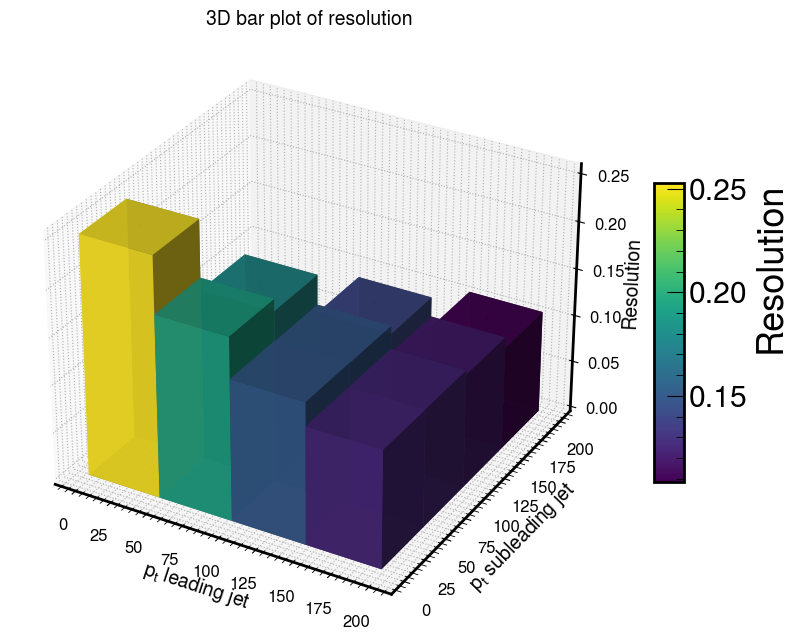

In [46]:
fig = plt.figure(figsize=(12, 8), dpi=100)
# coords come nel tuo esempio
coords = []
for x_index in [150, 100, 50, 0]:
    for y_index in [150, 100, 50, 0]:
        if x_index >= y_index:
            coords.append((x_index, y_index))

Z = sigmas[:, 0]
Zerr = sigmas[:, 1]

X = np.array([c[0] for c in coords])
Y = np.array([c[1] for c in coords])

dx = dy = 50
dz = Z

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Normalizza i valori di Z per mappare i colori
norm = mcolors.Normalize(vmin=np.min(Z), vmax=np.max(Z))
cmap = cm.viridis  # puoi scegliere anche 'plasma', 'coolwarm', ecc.
colors = cmap(norm(Z))

# Disegna barre con colori diversi
ax.bar3d(X, Y, np.zeros_like(Z), dx, dy, dz, shade=True, color=colors, alpha=0.9)

# Barre di errore verticali
for x, y, z, err in zip(X, Y, Z, Zerr):
    ax.plot([x+dx/2, x+dx/2], [y+dy/2, y+dy/2], [z, z+err], color='k')

# Aggiungi barra dei colori
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(Z)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label='Resolution')

ax.set_xlabel('$p_t$ leading jet', fontsize = 14)
ax.set_ylabel('$p_t$ subleading jet', fontsize = 14)
ax.set_zlabel('Resolution', fontsize = 14)
ax.set_title('3D bar plot of resolution', fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='z', which='major', labelsize=12)

plt.tight_layout()

plt.show()


<Figure size 1200x800 with 0 Axes>

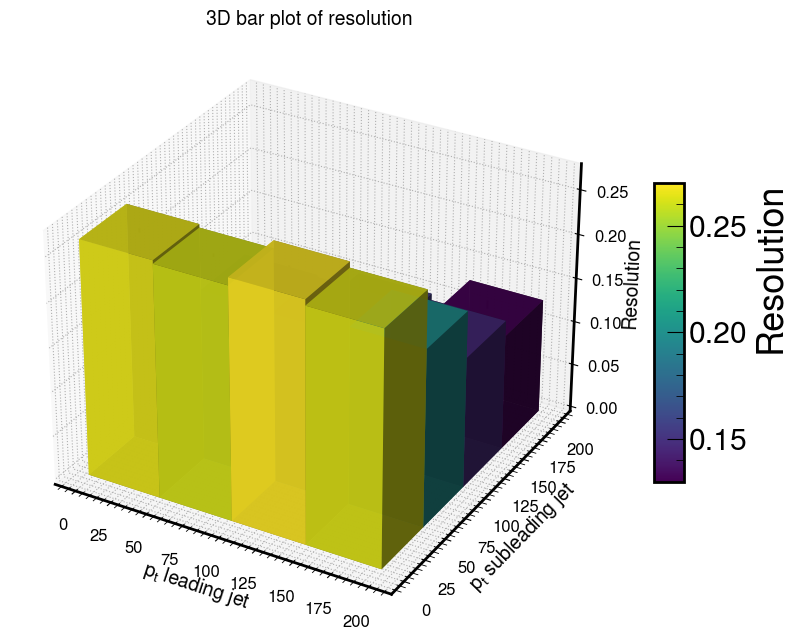

In [47]:
fig = plt.figure(figsize=(12, 8), dpi=100)
# coords come nel tuo esempio
coords = []
for x_index in [150, 100, 50, 0]:
    for y_index in [150, 100, 50, 0]:
        if x_index >= y_index:
            coords.append((x_index, y_index))

Z = sigmas[:, 2]
Zerr = sigmas[:, 3]

X = np.array([c[0] for c in coords])
Y = np.array([c[1] for c in coords])

dx = dy = 50
dz = Z

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Normalizza i valori di Z per mappare i colori
norm = mcolors.Normalize(vmin=np.min(Z), vmax=np.max(Z))
cmap = cm.viridis  # puoi scegliere anche 'plasma', 'coolwarm', ecc.
colors = cmap(norm(Z))

# Disegna barre con colori diversi
ax.bar3d(X, Y, np.zeros_like(Z), dx, dy, dz, shade=True, color=colors, alpha=0.9)

# Barre di errore verticali
for x, y, z, err in zip(X, Y, Z, Zerr):
    ax.plot([x+dx/2, x+dx/2], [y+dy/2, y+dy/2], [z, z+err], color='k')

# Aggiungi barra dei colori
mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
mappable.set_array(Z)
fig.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, label='Resolution')

ax.set_xlabel('$p_t$ leading jet', fontsize = 14)
ax.set_ylabel('$p_t$ subleading jet', fontsize = 14)
ax.set_zlabel('Resolution', fontsize = 14)
ax.set_title('3D bar plot of resolution', fontsize = 14)

ax.tick_params(axis='both', which='major', labelsize=12)
ax.tick_params(axis='z', which='major', labelsize=12)

plt.tight_layout()

plt.show()

## Evaluation of the efficiency of the selection of leading and subleading muons

### Selection of H --> $\mu\mu$ muons using the particle generator

In [48]:
ROOT.gInterpreter.Declare("""
std::vector<int> findHiggsMuMuDecay(
    const ROOT::VecOps::RVec<int>& pdgId,
    const ROOT::VecOps::RVec<int>& motherIdx,
    const ROOT::VecOps::RVec<float>& pt
) {
    std::vector<int> result;

    // 1. Trova tutti gli Higgs
    for (size_t i = 0; i < pdgId.size(); ++i) {
        if (pdgId[i] != 25) continue; // non è un Higgs

        // 2. Trova i figli di questo Higgs
        std::vector<int> muons;
        for (size_t j = 0; j < pdgId.size(); ++j) {
            if (motherIdx[j] == (int)i) { // il padre è l'Higgs corrente
                if (pdgId[j] == 13 || pdgId[j] == -13) {
                    muons.push_back(j);
                }
            }
        }

        // 3. Controlla se abbiamo esattamente un mu+ e un mu-
        if (muons.size() == 2 && ((pdgId[muons[0]] == 13 && pdgId[muons[1]] == -13) || (pdgId[muons[0]] == -13 && pdgId[muons[1]] == 13))) {

            // 4. Ordina per pT
            if (pt[muons[0]] > pt[muons[1]]) {
                result = {muons[0], muons[1]};
            } else {
                result = {muons[1], muons[0]};
            }
            return result; // Restituisci la prima coppia trovata
        }
    }

    return {}; // Nessun Higgs -> mu+ mu-
}
""")


True

In [49]:
df_twomuons_sig = (
    df_twomuons_sig.Define("Muon_gen_indices", "findHiggsMuMuDecay(GenPart_pdgId, GenPart_genPartIdxMother, GenPart_pt)")
    .Filter("Muon_gen_indices.size() == 2", "HiggsMuMu event found")
    .Define("Muon_gen_idx1", "Muon_gen_indices[0]")
    .Define("Muon_gen_idx2", "Muon_gen_indices[1]")
    
    .Define("Muon_gen1_pt", "GenPart_pt[Muon_gen_idx1]")
    .Define("Muon_gen1_eta", "GenPart_eta[Muon_gen_idx1]")
    .Define("Muon_gen1_phi", "GenPart_phi[Muon_gen_idx1]")
    .Define("Muon_gen1_mass", "GenPart_mass[Muon_gen_idx1]")
    .Define("Muon_gen2_pt", "GenPart_pt[Muon_gen_idx2]")
    .Define("Muon_gen2_eta", "GenPart_eta[Muon_gen_idx2]")
    .Define("Muon_gen2_phi", "GenPart_phi[Muon_gen_idx2]")
    .Define("Muon_gen2_mass", "GenPart_mass[Muon_gen_idx2]")

     #adds to the dataframe the differences in pt, eta, phi and R
    .Define("Muon_gen_DeltaPt", "Muon_gen1_pt - Muon_gen2_pt")
    .Define("Muon_gen_DeltaPhi", "DeltaPhiFunc(Muon_gen1_phi, Muon_gen2_phi)")
    .Define("Muon_gen_DeltaEta", "abs(Muon_gen1_eta - Muon_gen2_eta)")
    .Define("Muon_gen_DeltaR", "sqrt(pow(Muon_gen_DeltaEta,2) + pow(Muon_gen_DeltaPhi,2))")

    # adds to the dataframe the variables related to the diquark system
    .Define("Dimuon_gen_LV", "sum_TLorentzVector(Muon_gen1_pt, Muon_gen1_eta, Muon_gen1_phi, Muon_gen1_mass, Muon_gen2_pt, Muon_gen2_eta, Muon_gen2_phi, Muon_gen2_mass)")
    .Define("Dimuon_gen_pt", "Dimuon_gen_LV.Pt()")
    .Define("Dimuon_gen_eta", "Dimuon_gen_LV.Eta()")
    .Define("Dimuon_gen_phi", "Dimuon_gen_LV.Phi()")
    .Define("Dimuon_gen_m", "Dimuon_gen_LV.M()")
)

In [50]:
ROOT.gInterpreter.Declare("""
#include <tuple>
std::tuple<std::vector<int>, double, double> match_gen_mu_to_mu(
    double Muon_gen1_eta, double Muon_gen1_phi,
    double Muon_gen2_eta, double Muon_gen2_phi,
    const ROOT::VecOps::RVec<float>& Muon_eta,
    const ROOT::VecOps::RVec<float>& Muon_phi) {

    std::vector<int> matched_mu_indices(2, -1);
    
    // Primo muone
    double min_dr1 = 999.0;
    double min_dr12 = 999.0;
    int best_mu_idx1 = -1;
    int best_mu_idx12 = -1;
    for (size_t i = 0; i < Muon_eta.size(); ++i) {
        double d_phi = EvaluateDeltaPhi(Muon_gen1_phi, Muon_phi[i]);
        double d_eta = std::abs(Muon_gen1_eta - Muon_eta[i]);
        double dr = std::sqrt(d_eta * d_eta + d_phi * d_phi);
        if (dr < min_dr1) {
            min_dr12 = min_dr1;
            best_mu_idx12 = best_mu_idx1;
            min_dr1 = dr;
            best_mu_idx1 = i;
        } else if (dr < min_dr12 && dr >= min_dr1){
            min_dr12 = dr;
            best_mu_idx12 = i;
        }
    }

    // Secondo muone
    double min_dr2 = 999.0;
    double min_dr22 = 999.0;
    int best_mu_idx2 = -1;
    int best_mu_idx22 = -1;
    for (size_t i = 0; i < Muon_eta.size(); ++i) {
        double d_phi = EvaluateDeltaPhi(Muon_gen2_phi, Muon_phi[i]);
        double d_eta = std::abs(Muon_gen2_eta - Muon_eta[i]);
        double dr = std::sqrt(d_eta * d_eta + d_phi * d_phi);
        if (dr < min_dr2) {
            min_dr22 = min_dr2;
            best_mu_idx22 = best_mu_idx2;
            min_dr2 = dr;
            best_mu_idx2 = i;
        } else if (dr < min_dr22 && dr >= min_dr2){
            min_dr22 = dr;
            best_mu_idx22 = i;
        }
    }      
    
    // controlla che i due quark non siano stati associati allo stesso jet e risolve le eventuali ambiguità
    if (best_mu_idx1 == best_mu_idx2){
        if (min_dr1 < min_dr2){
            best_mu_idx2 = best_mu_idx22;
            min_dr2 = min_dr22;
        } else {
            best_mu_idx1 = best_mu_idx12;
            min_dr1 = min_dr12;
        }
    }
                          
    matched_mu_indices[0] = best_mu_idx1;                     
    matched_mu_indices[1] = best_mu_idx2;
    
    return std::make_tuple(matched_mu_indices, min_dr1, min_dr2);
}
""");

In [51]:
df_twomuons_sig = (
    df_twomuons_sig
    # calcola il vettore degli indici dei jet matched
    .Define("mu_match_tuple", "match_gen_mu_to_mu(Muon_gen1_eta, Muon_gen1_phi, Muon_gen2_eta, Muon_gen2_phi, Muon_eta, Muon_phi)")
    
    # Estrai la lista degli indici jet
    .Define("MuonReco_indices", "std::get<0>(mu_match_tuple)")
    .Define("MuonGenReco1_DeltaR", "(double) std::get<1>(mu_match_tuple)")
    .Define("MuonGenReco2_DeltaR", "(double) std::get<2>(mu_match_tuple)")
    
    # adds to the dataframe the deltaR between the two quarks and their related jets
    .Define("MuonReco1_idx", "MuonReco_indices[0]")
    .Define("MuonReco2_idx", "MuonReco_indices[1]")

    # filtra eventi in cui entrambi gli indici sono validi (>=0) e che DeltaR <= 0.02
    .Filter("MuonReco1_idx >= 0 && MuonReco2_idx >=0", "Valid matched muons")
    .Filter("MuonGenReco1_DeltaR <= 0.02 && MuonGenReco2_DeltaR <= 0.02", "Delta_R_GenReco <= 0.02")

    # adds to the dataframe columns containing the variables of the jets
    .Define("Muon_reco1_pt", "Muon_pt[MuonReco1_idx]")
    .Define("Muon_reco1_eta", "Muon_eta[MuonReco1_idx]")
    .Define("Muon_reco1_phi", "Muon_phi[MuonReco1_idx]")
    .Define("Muon_reco1_mass", "Muon_mass[MuonReco1_idx]")

    .Define("Muon_reco2_pt", "Muon_pt[MuonReco2_idx]")
    .Define("Muon_reco2_eta", "Muon_eta[MuonReco2_idx]")
    .Define("Muon_reco2_phi", "Muon_phi[MuonReco2_idx]")
    .Define("Muon_reco2_mass", "Muon_mass[MuonReco2_idx]")

    # adds to the dataframe the differences in pt, eta, phi and R
    .Define("Muon_reco_DeltaPt", "Muon_reco1_pt - Muon_reco2_pt")
    .Define("Muon_reco_DeltaEta", "abs(Muon_reco1_eta - Muon_reco2_eta)")
    .Define("Muon_reco_DeltaPhi", "EvaluateDeltaPhi(Muon_reco1_phi, Muon_reco2_phi)")
    .Define("Muon_reco_DeltaR", "sqrt(pow(Muon_reco_DeltaEta,2) + pow(Muon_reco_DeltaPhi,2))")

    # adds to the dataframe the variables related to the dijet system
    .Define("Dimuon_reco_LV", "sum_TLorentzVector(Muon_reco1_pt, Muon_reco1_eta, Muon_reco1_phi, Muon_reco1_mass, Muon_reco2_pt, Muon_reco2_eta, Muon_reco2_phi, Muon_reco2_mass)")
    .Define("Dimuon_reco_pt", "Dimuon_reco_LV.Pt()")
    .Define("Dimuon_reco_eta", "Dimuon_reco_LV.Eta()")
    .Define("Dimuon_reco_phi", "Dimuon_reco_LV.Phi()")
    .Define("Dimuon_reco_m", "Dimuon_reco_LV.M()")
)

In [52]:
# distribution of DeltaR between the Gen and Reco muons
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "MuonGenReco1_DeltaR", "MuonGenReco2_DeltaR", 20, 0, 0.02, 20, 0, 0.02, "#DeltaR", "Events", "Delta_R leading muon", "Delta_R subleading muon")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "MuonGenReco1_DeltaR", "MuonGenReco2_DeltaR", 15, 0.005, 0.02, 15, 0.005, 0.02, "#DeltaR", "Events", "Delta_R leading muon", "Delta_R subleading muon")

### Comparison between Gen and Reco level

In [53]:
# plots the histogram of pt for the two muons at Gen and Reco level
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Muon_gen1_pt", "Muon_gen2_pt", "Muon_reco1_pt", "Muon_reco2_pt", 40, 0, 300, 40, 0, 300, 40, 0, 300, 40, 0, 300, "p_{T} [GeV]", "Events", "Leading muon Gen level", "Subleading muon Gen level", "Leading muon Reco level", "Subleading muon Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon_gen_DeltaPt", "Muon_reco_DeltaPt", 40, 0, 250, 40, 0, 250,"#Deltap_{T} [GeV]", "Events", "Gen level", "Reco level")

# plots the histogram of phi for the two muons at Gen and Reco level
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Muon_gen1_phi", "Muon_gen2_phi", "Muon_reco1_phi", "Muon_reco2_phi", 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, "#phi [rad]", "Events", "Leading muon Gen level", "Subleading muon Gen level", "Leading muon Reco level", "Subleading muon Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon_gen_DeltaPhi", "Muon_reco_DeltaPhi", 30, 0, math.pi, 30, 0, math.pi, "#Delta#phi [rad]", "Events", "Gen level", "Reco level")

# plots the histogram of eta for the two muons at Gen and Reco level
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Muon_gen1_eta", "Muon_gen2_eta", "Muon_reco1_eta", "Muon_reco2_eta", 30, -2.4, 2.4, 30, -2.4, 2.4, 30, -2.4, 2.4, 30, -2.4, 2.4, "#eta", "Events", "Leading muon Gen level", "Subleading muon Gen level", "Leading muon Reco level", "Subleading muon Reco level")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon_gen_DeltaEta", "Muon_reco_DeltaEta", 30, 0, 4.8, 30, 0, 4.8, "#Delta#eta", "Events", "Gen level", "Reco level")

# plots the histogram of the DeltaR at Gen and Reco level
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon_gen_DeltaR", "Muon_reco_DeltaR", 40, 0, 5, 40, 0, 5, "#DeltaR", "Events", "Gen level", "Reco level")

# plots the histogram of the mass of the two muons at Gen and Reco level
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Muon_gen1_mass", "Muon_gen2_mass", "Muon_reco1_mass", "Muon_reco2_mass", 40, 0, 0.2, 40, 0, 0.2, 40, 0, 0.2, 40, 0, 0.2, "m_{#mu} [GeV]", "Events", "Leading muon Gen level", "Subleading muon Gen level", "Leading muon Reco level", "Subleading muon Reco level")

### Comparison between the leading/subleading algorithm and the muon matching at Gen level

In [54]:
# plots the histogram of pt for the two muons using the generator and using the leading and subleading muons
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Muon_reco1_pt", "Muon_reco2_pt", "Muon1_pt", "Muon2_pt", 40, 0, 300, 40, 0, 300, 40, 0, 300, 40, 0, 300, "p_{T} [GeV]", "Events", "Leading muon Gen level", "Subleading muon Gen level", "Leading muon", "Subleading muon")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon_reco_DeltaPt", "Muon_DeltaPt", 40, 0, 250, 40, 0, 250,"#Deltap_{T} [GeV]", "Events", "Gen level", "Leading and subleading muons")

# plots the histogram of phi for the two muons using the generator and using the leading and subleading muons
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Muon_reco1_phi", "Muon_reco2_phi", "Muon1_phi", "Muon2_phi", 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, "#phi [rad]", "Events", "Leading muon Gen level", "Subleading muon Gen level", "Leading muon", "Subleading muon")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon_reco_DeltaPhi", "Muon_DeltaPhi", 30, 0, math.pi, 30, 0, math.pi, "#Delta#phi [rad]", "Events", "Gen level", "Leading and subleading muons")

# plots the histogram of eta for the two muons using the generator and using the leading and subleading muons
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Muon_reco1_eta", "Muon_reco2_eta", "Muon1_eta", "Muon2_eta", 30, -2.4, 2.4, 30, -2.4, 2.4, 30, -2.4, 2.4, 30, -2.4, 2.4, "#eta", "Events", "Leading muon Gen level", "Subleading muon Gen level", "Leading muon", "Subleading muon")
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon_reco_DeltaEta", "Muon_DeltaEta", 30, 0, 4.8, 30, 0, 4.8, "#Delta#eta", "Events", "Gen level", "Leading and subleading muons")

# plots the histogram of the DeltaR using the generator and using the leading and subleading muons
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon_reco_DeltaR", "Muon_DeltaR", 40, 0, 5, 40, 0, 5, "#DeltaR", "Events", "Gen level", "Leading and subleading muons")

# plots the histogram of the mass of the two muons using the generator and using the leading and subleading muons
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, df_twomuons_sig, "Muon_reco1_mass", "Muon_reco2_mass", "Muon1_mass", "Muon2_mass", 40, 0, 0.2, 40, 0, 0.2, 40, 0, 0.2, 40, 0, 0.2, "m_{jet} [GeV]", "Events", "Leading muon Gen level", "Subleading muon Gen level", "Leading muon", "Subleading muon")

In [55]:
# Lista delle coppie di colonne da confrontare
pairs = [
    ("Muon1_pt", "Muon_reco1_pt"),
    ("Muon2_pt", "Muon_reco2_pt"),
    ("Muon1_eta", "Muon_reco1_eta"),
    ("Muon2_eta", "Muon_reco2_eta"),
    ("Muon1_phi", "Muon_reco1_phi"), 
    ("Muon2_phi", "Muon_reco2_phi"),
]

# Numero totale di eventi
n_total = df_twomuons_sig.Count().GetValue()

# Calcolo per ogni coppia
percentages = {}
for c1, c2 in pairs:
    n_equal = df_twomuons_sig.Filter(f"{c1} == {c2}").Count().GetValue()
    percentages[(c1, c2)] = (n_equal / n_total) * 100

# Mostra le percentuali singole
for (c1, c2), perc in percentages.items():
    print(f"Coppia ({c1}, {c2}): {perc:.3f}% eventi uguali")

# Calcolo della percentuale complessiva (tutte uguali)
condition_all = " && ".join([f"{c1} == {c2}" for c1, c2 in pairs])
n_equal_all = df_twomuons_sig.Filter(condition_all).Count().GetValue()
perc_all = (n_equal_all / n_total) * 100

print(f"Percentuale complessiva (tutte le coppie uguali): {perc_all:.3f}%")

Coppia (Muon1_pt, Muon_reco1_pt): 98.613% eventi uguali
Coppia (Muon2_pt, Muon_reco2_pt): 98.611% eventi uguali
Coppia (Muon1_eta, Muon_reco1_eta): 98.613% eventi uguali
Coppia (Muon2_eta, Muon_reco2_eta): 98.611% eventi uguali
Coppia (Muon1_phi, Muon_reco1_phi): 98.613% eventi uguali
Coppia (Muon2_phi, Muon_reco2_phi): 98.611% eventi uguali
Percentuale complessiva (tutte le coppie uguali): 98.611%


### Evaluation of the resolution of the matching muons

In [56]:
df_twomuons_sig = (
    df_twomuons_sig.Define("Muon_pt1_reso", "(Muon1_pt-Muon_reco1_pt)/Muon_reco1_pt")
    .Define("Muon_pt2_reso", "(Muon2_pt-Muon_reco2_pt)/Muon_reco2_pt")
)

In [57]:
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "Leading muon", "Subleading muon")

In [58]:
df_Muon_150_150_pt = df_twomuons_sig.Filter("Muon_reco1_pt>= 150 && Muon_reco2_pt >= 150")
df_Muon_150_100_pt = df_twomuons_sig.Filter("(Muon_reco1_pt>= 150 && Muon_reco2_pt >= 100 && Muon_reco2_pt < 150)")
df_Muon_150_50_pt = df_twomuons_sig.Filter("(Muon_reco1_pt>= 150 && Muon_reco2_pt >= 50 && Muon_reco2_pt < 100)")
df_Muon_150_0_pt = df_twomuons_sig.Filter("(Muon_reco1_pt>= 150 && Muon_reco2_pt < 50)")
df_Muon_100_100_pt = df_twomuons_sig.Filter("(Muon_reco1_pt>= 100 && Muon_reco1_pt < 150 && Muon_reco2_pt >= 100 && Muon_reco2_pt < 150)")
df_Muon_100_50_pt = df_twomuons_sig.Filter("(Muon_reco1_pt>= 100 && Muon_reco1_pt < 150 && Muon_reco2_pt >= 50 && Muon_reco2_pt < 100)")
df_Muon_100_0_pt = df_twomuons_sig.Filter("(Muon_reco1_pt>= 100 && Muon_reco1_pt < 150 && Muon_reco2_pt < 50)")
df_Muon_50_50_pt = df_twomuons_sig.Filter("(Muon_reco1_pt>= 50 && Muon_reco1_pt < 100 && Muon_reco2_pt >= 50 && Muon_reco2_pt < 100)")
df_Muon_50_0_pt = df_twomuons_sig.Filter("(Muon_reco1_pt>= 50 && Muon_reco1_pt < 100 && Muon_reco2_pt < 50)")
df_Muon_0_0_pt = df_twomuons_sig.Filter("Muon_reco1_pt < 50 && Muon_reco2_pt < 50")

In [59]:
sigmas = []
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_150_150_pt, df_Muon_150_150_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}>150 GeV", "p_{T}^{SL}>150 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_150_100_pt, df_Muon_150_100_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}>150 GeV", "100 GeV<p_{T}^{SL}<150 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_150_50_pt, df_Muon_150_50_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}>150 GeV", "50 GeV<p_{T}^{SL}<100 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_150_0_pt, df_Muon_150_0_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}>150 GeV", "p_{T}^{SL}<50 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_100_100_pt, df_Muon_100_100_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "100 GeV<p_{T}^{L}<150 GeV", "100 GeV<p_{T}^{SL}<150 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_100_50_pt, df_Muon_100_50_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "100 GeV<p_{T}^{L}<150 GeV", "50 GeV<p_{T}^{SL}<100 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_100_0_pt, df_Muon_100_0_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "100 GeV<p_{T}^{L}<150 GeV", "p_{T}^{SL}<50 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_50_50_pt, df_Muon_50_50_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "50 GeV<p_{T}^{L}<100 GeV", "50 GeV<p_{T}^{SL}<100 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_50_0_pt, df_Muon_50_0_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "50 GeV<p_{T}^{L}<100 GeV", "p_{T}^{SL}<50 GeV"))
sigmas.append(plot2Histo1D_fitgauss_df(df_Muon_0_0_pt, df_Muon_0_0_pt, "Muon_pt1_reso", "Muon_pt2_reso", 40, -0.2, 0.2, 40, -0.2, 0.2, "(p_{T}^{reco}-p_{T}^{gen})/p_{T}^{gen}", "Events", "p_{T}^{L}<50 GeV", "p_{T}^{SL}<50 GeV"))

sigmas = np.array(sigmas)
print(sigmas)

[[3.04866580e-03 2.59704536e-03 1.48518387e-03 4.94127373e-03]
 [1.73886866e-01 1.92247044e-01 1.73886866e-01 1.92247044e-01]
 [2.25622772e-01 1.54045561e-01 2.25622772e-01 1.54045561e-01]
 [1.52772228e-01 6.92480787e-02 1.52772228e-01 6.92480787e-02]
 [1.92035200e-02 2.52174442e-03 7.31972900e-04 9.21097469e-02]
 [5.82076609e-11 0.00000000e+00 5.82076609e-11 0.00000000e+00]
 [1.52768172e-01 4.48540625e-02 1.52768172e-01 4.48540625e-02]
 [3.73766115e-03 2.79937914e-04 3.03372093e-03 3.69473806e-04]
 [1.52767210e-01 3.69192568e-02 1.52767210e-01 3.69205802e-02]
 [3.96611202e-03 6.71632763e-04 3.79791917e-03 1.63979267e-04]]


### pt balance 

In [60]:
df_twomuons_sig = (
    df_twomuons_sig    
    # adds to the dataframe the variables related to the sum of the Lorentz vector of the dimuon and the dijet systems at Gen Level
    .Define("jj_dimuon_gen_LV", "qq_LV + Dimuon_gen_LV")
    .Define("jj_dimuon_gen_pt", "jj_dimuon_gen_LV.Pt()")

    # adds to the dataframe the variables related to the sum of the Lorentz vector of the dimuon and the dijet systems at Reco Level
    .Define("jj_dimuon_reco_LV", "jj_LV + Dimuon_reco_LV")
    .Define("jj_dimuon_reco_pt", "jj_dimuon_reco_LV.Pt()")
)

In [61]:
plot2Histo1D_df(df_twomuons_sig, df_twomuons_sig, "jj_dimuon_gen_pt", "jj_dimuon_reco_pt", 40, 0, 100, 40, 0, 100,"p_{T} balance [GeV]", "Events", "Gen level", "Reco level")

## Variables to train the DNN

### Creates the variables for muons used to train the DNN

In [62]:
# applies filters to the signal dataset
df_DNN_sig = (
    dataframe_sig.Filter("HLT_IsoMu24 == true", "HLT_IsoMu24 cut")
    .Filter("All(Muon_tightId == true)", "tightId cut")
    .Filter("All(Muon_pfIsoId >=4)", "pfIsoId tight cut")
    .Filter("All(Muon_eta < 2.4) && All (Muon_eta > -2.4)", "Eta cut 2.4")
    .Filter("All(Jet_eta < 5) && All (Jet_eta > -5)", "Eta cut 5")
     #.Filter("All(Jet_btagPNetB < 0.6)", "btag cut")
    .Filter("nMuon >= 2", "two or more muons")
    .Filter("nJet >= 2", "two or more jets")
    .Filter("Any(Muon_charge == 1) && Any(Muon_charge == -1)", "2 muons with opposite charge")
    .Filter("Muon_pt[0] > 25", "Muon1_pt > 25")
)

# applies to the background dataset the same cuts applied in the High Level Trigger in the signal dataset
df_DNN_bkg = (
    dataframe_bkg.Filter("HLT_IsoMu24 == true", "HLT_IsoMu24 cut")
    .Filter("All(Muon_tightId == true)", "tightId cut")
    .Filter("All(Muon_pfIsoId >=4)", "pfIsoId tight cut")
    .Filter("All(Muon_eta < 2.4) && All (Muon_eta > -2.4)", "Eta cut 2.4")
    .Filter("All(Jet_eta < 5) && All (Jet_eta > -5)", "Eta cut 5")
     #.Filter("All(Jet_btagPNetB < 0.6)", "btag cut")
    .Filter("nMuon >= 2", "two or more muons")
    .Filter("nJet >= 2", "two or more jets")
    .Filter("Any(Muon_charge == 1) && Any(Muon_charge == -1)", "2 muons with opposite charge")
    .Filter("Muon_pt[0] > 25", "Muon1_pt > 25")
)

In [63]:
df_DNN_sig = (
    # Trova coppia (leading/subleading in pT)
    df_DNN_sig.Define("opp_pair", "FindOppositeChargePair(Muon_pt, Muon_charge)")

    # Indici separati
    .Define("idx_mu1", "opp_pair.first")
    .Define("idx_mu2", "opp_pair.second")

    # Filtra solo eventi dove coppia esiste
    .Filter("idx_mu1 >= 0 && idx_mu2 >= 0", "Opposite charge pair found")

    # adds to the dataframe columns containing the leading muon variables
    .Define("Muon1_pt", "Muon_pt[idx_mu1]")
    .Define("Muon1_eta", "Muon_eta[idx_mu1]")
    .Define("Muon1_phi", "Muon_phi[idx_mu1]")
    .Define("Muon1_mass", "Muon_mass[idx_mu1]")

    # adds to the dataframe columns containing the subleading muon variables
    .Define("Muon2_pt", "Muon_pt[idx_mu2]")
    .Define("Muon2_eta", "Muon_eta[idx_mu2]")
    .Define("Muon2_phi", "Muon_phi[idx_mu2]")
    .Define("Muon2_mass", "Muon_mass[idx_mu2]")

    # adds to the dataframe the differences in pt, eta, phi and R
    .Define("Muon_DeltaPt", "Muon1_pt - Muon2_pt")
    .Define("Muon_DeltaPhi", "EvaluateDeltaPhi(Muon1_phi, Muon2_phi)")
    .Define("Muon_DeltaEta", "abs(Muon1_eta - Muon2_eta)")
    .Define("Muon_DeltaR", "sqrt(pow(Muon_DeltaEta, 2) + pow(Muon_DeltaPhi, 2))")

    # adds to the dataframe the variables related to the dimuon system
    .Define("Dimuon_LV", "sum_TLorentzVector(Muon1_pt, Muon1_eta, Muon1_phi, Muon1_mass, Muon2_pt, Muon2_eta, Muon2_phi, Muon2_mass)")
    .Define("Dimuon_pt", "Dimuon_LV.Pt()")
    .Define("Dimuon_eta", "Dimuon_LV.Eta()")
    .Define("Dimuon_phi", "Dimuon_LV.Phi()")
    .Define("Dimuon_mass", "Dimuon_LV.M()")


    # adds to the dataframe columns containing the variables of the leading and subleading jets
    .Define("JetL_pt", "Jet_pt[0]")
    .Define("JetL_eta", "Jet_eta[0]")
    .Define("JetL_phi", "Jet_phi[0]")
    .Define("JetL_mass", "Jet_mass[0]")

    .Define("JetS_pt", "Jet_pt[1]")
    .Define("JetS_eta", "Jet_eta[1]")
    .Define("JetS_phi", "Jet_phi[1]")
    .Define("JetS_mass", "Jet_mass[1]")

    # adds to the dataframe the differences in pt, eta, phi and R
    .Define("JetLS_DeltaPt", "JetL_pt - JetS_pt")
    .Define("JetLS_DeltaEta", "abs(JetL_eta - JetS_eta)")
    .Define("JetLS_DeltaPhi", "EvaluateDeltaPhi(JetL_phi, JetS_phi)")
    .Define("JetLS_DeltaR", "sqrt(pow(JetLS_DeltaEta,2) + pow(JetLS_DeltaPhi,2))")

    # adds to the dataframe the variables related to the dijet system
    .Define("jjLS_LV", "sum_TLorentzVector(JetL_pt, JetL_eta, JetL_phi, JetL_mass, JetS_pt, JetS_eta, JetS_phi, JetS_mass)")
    .Define("jjLS_pt", "jjLS_LV.Pt()")
    .Define("jjLS_eta", "jjLS_LV.Eta()")
    .Define("jjLS_phi", "jjLS_LV.Phi()")
    .Define("jjLS_m", "jjLS_LV.M()")
)

In [64]:
df_DNN_bkg = (
    # Trova coppia (leading/subleading in pT)
    df_DNN_bkg.Define("opp_pair", "FindOppositeChargePair(Muon_pt, Muon_charge)")

    # Indici separati
    .Define("idx_mu1", "opp_pair.first")
    .Define("idx_mu2", "opp_pair.second")

    # Filtra solo eventi dove coppia esiste
    .Filter("idx_mu1 >= 0 && idx_mu2 >= 0", "Opposite charge pair found")

    # adds to the dataframe columns containing the leading muon variables
    .Define("Muon1_pt", "Muon_pt[idx_mu1]")
    .Define("Muon1_eta", "Muon_eta[idx_mu1]")
    .Define("Muon1_phi", "Muon_phi[idx_mu1]")
    .Define("Muon1_mass", "Muon_mass[idx_mu1]")

    # adds to the dataframe columns containing the subleading muon variables
    .Define("Muon2_pt", "Muon_pt[idx_mu2]")
    .Define("Muon2_eta", "Muon_eta[idx_mu2]")
    .Define("Muon2_phi", "Muon_phi[idx_mu2]")
    .Define("Muon2_mass", "Muon_mass[idx_mu2]")

    # adds to the dataframe the differences in pt, eta, phi and R
    .Define("Muon_DeltaPt", "Muon1_pt - Muon2_pt")
    .Define("Muon_DeltaPhi", "EvaluateDeltaPhi(Muon1_phi, Muon2_phi)")
    .Define("Muon_DeltaEta", "abs(Muon1_eta - Muon2_eta)")
    .Define("Muon_DeltaR", "sqrt(pow(Muon_DeltaEta, 2) + pow(Muon_DeltaPhi, 2))")

    # adds to the dataframe the variables related to the dimuon system
    .Define("Dimuon_LV", "sum_TLorentzVector(Muon1_pt, Muon1_eta, Muon1_phi, Muon1_mass, Muon2_pt, Muon2_eta, Muon2_phi, Muon2_mass)")
    .Define("Dimuon_pt", "Dimuon_LV.Pt()")
    .Define("Dimuon_eta", "Dimuon_LV.Eta()")
    .Define("Dimuon_phi", "Dimuon_LV.Phi()")
    .Define("Dimuon_mass", "Dimuon_LV.M()")


    # adds to the dataframe columns containing the variables of the leading and subleading jets
    .Define("JetL_pt", "Jet_pt[0]")
    .Define("JetL_eta", "Jet_eta[0]")
    .Define("JetL_phi", "Jet_phi[0]")
    .Define("JetL_mass", "Jet_mass[0]")

    .Define("JetS_pt", "Jet_pt[1]")
    .Define("JetS_eta", "Jet_eta[1]")
    .Define("JetS_phi", "Jet_phi[1]")
    .Define("JetS_mass", "Jet_mass[1]")

    # adds to the dataframe the differences in pt, eta, phi and R
    .Define("JetLS_DeltaPt", "JetL_pt - JetS_pt")
    .Define("JetLS_DeltaEta", "abs(JetL_eta - JetS_eta)")
    .Define("JetLS_DeltaPhi", "EvaluateDeltaPhi(JetL_phi, JetS_phi)")
    .Define("JetLS_DeltaR", "sqrt(pow(JetLS_DeltaEta,2) + pow(JetLS_DeltaPhi,2))")

    # adds to the dataframe the variables related to the dijet system
    .Define("jjLS_LV", "sum_TLorentzVector(JetL_pt, JetL_eta, JetL_phi, JetL_mass, JetS_pt, JetS_eta, JetS_phi, JetS_mass)")
    .Define("jjLS_pt", "jjLS_LV.Pt()")
    .Define("jjLS_eta", "jjLS_LV.Eta()")
    .Define("jjLS_phi", "jjLS_LV.Phi()")
    .Define("jjLS_m", "jjLS_LV.M()")
)

In [65]:
ROOT.gInterpreter.Declare("""
float ComputeSigmaMassDimuon(
    float pt1,  float eta1,  float phi1,
    float s_pt1, float s_eta1, float s_phi1,
    float pt2,  float eta2,  float phi2,
    float s_pt2, float s_eta2, float s_phi2
) {
    // Differenze cinematiche
    float d_eta = eta1 - eta2;
    float d_phi = phi1 - phi2;

    // Invariante: m^2 = 2 * pt1 * pt2 * (cosh(deta) - cos(dphi))
    float f = std::cosh(d_eta) - std::cos(d_phi);
    float m = std::sqrt(2.0f * pt1 * pt2 * f);

    // Evita divisione per zero
    if (m <= 0.0f) {
        return 0.0f;
    }

    // Derivate parziali
    float dm_dpt1  = (pt2 * f) / m;
    float dm_dpt2  = (pt1 * f) / m;
    float dm_deta1 = (pt1 * pt2 * std::sinh(d_eta)) / m;
    float dm_deta2 = -(pt1 * pt2 * std::sinh(d_eta)) / m;
    float dm_dphi1 = (pt1 * pt2 * std::sin(d_phi)) / m;
    float dm_dphi2 = -(pt1 * pt2 * std::sin(d_phi)) / m;

    // Propagazione errori (senza termini di covarianza)
    float sigma_m = std::sqrt(
        std::pow(dm_dpt1  * s_pt1,  2) +
        std::pow(dm_dpt2  * s_pt2,  2) +
        std::pow(dm_deta1 * s_eta1, 2) +
        std::pow(dm_deta2 * s_eta2, 2) +
        std::pow(dm_dphi1 * s_phi1, 2) +
        std::pow(dm_dphi2 * s_phi2, 2)
    );

    return sigma_m;
}
""")

True

In [66]:
ROOT.gInterpreter.Declare("""
#include <cmath>
#include <algorithm>

const float MUON_MASS = 0.1056583745; // GeV

float wrap_dphi(float dphi) {
    // Wrap Δφ in [-π, π]
    const float pi = 3.14159265358979323846f;
    return std::fmod(dphi + pi, 2*pi) - pi;
}

float ComputeSigmaMassDimuon_ptErrOnly(
    float pt1,  float eta1,  float phi1,  float s_pt1,
    float pt2,  float eta2,  float phi2,  float s_pt2,
    bool massless
) {
    // Differenze cinematiche
    float d_eta = eta1 - eta2;
    float d_phi = wrap_dphi(phi1 - phi2);

    const float eps = 1e-12f;
    float mass = 0.0f;
    float denom = eps;
    float sigma_mass = 0.0f;

    if (massless) {
        // Massa zero
        float f = std::cosh(d_eta) - std::cos(d_phi);
        float m2 = 2.0f * pt1 * pt2 * f;
        mass = std::sqrt(std::max(m2, 0.0f));
        denom = (mass > eps) ? mass : eps;

        // Derivate rispetto a pt
        float dm_dpt1 = (pt2 * f) / denom;
        float dm_dpt2 = (pt1 * f) / denom;

        // Propagazione errore (solo pt)
        sigma_mass = std::sqrt(
            std::pow(dm_dpt1 * s_pt1, 2) +
            std::pow(dm_dpt2 * s_pt2, 2)
        );
    } else {
        // Massa reale muone
        float ET1 = std::sqrt(pt1*pt1 + MUON_MASS*MUON_MASS);
        float ET2 = std::sqrt(pt2*pt2 + MUON_MASS*MUON_MASS);
        float m2 = 2*ET1*ET2*std::cosh(d_eta) - 2*pt1*pt2*std::cos(d_phi) + 2*MUON_MASS*MUON_MASS;
        mass = std::sqrt(std::max(m2, 0.0f));
        denom = (mass > eps) ? mass : eps;

        float dET1_dpt1 = pt1 / ET1;
        float dET2_dpt2 = pt2 / ET2;

        float dm_dpt1 = (ET2 * dET1_dpt1 * std::cosh(d_eta) - pt2 * std::cos(d_phi)) / denom;
        float dm_dpt2 = (ET1 * dET2_dpt2 * std::cosh(d_eta) - pt1 * std::cos(d_phi)) / denom;

        sigma_mass = std::sqrt(
            std::pow(dm_dpt1 * s_pt1, 2) +
            std::pow(dm_dpt2 * s_pt2, 2)
        );
    }

    return sigma_mass;
}
""")

True

In [67]:
df_DNN_sig = (
    df_DNN_sig
    # adds to the dataframe the uncertainties on pt, eta and phi for the two muons
    .Define("Muon1_ptErr", "Muon_ptErr[idx_mu1]")
    .Define("Muon2_ptErr", "Muon_ptErr[idx_mu2]")

    # adds to the dataframe the uncertainty on the dimuon mass
    .Define("Sigma_Dimuon_mass", "ComputeSigmaMassDimuon_ptErrOnly(Muon1_pt, Muon1_eta, Muon1_phi, Muon1_ptErr, Muon2_pt, Muon2_eta, Muon2_phi, Muon2_ptErr, false)")
    # Filtra solo eventi dove l'incertezza è > 0
    .Filter("Sigma_Dimuon_mass > 0", "sigma dimuon mass found")
)


df_DNN_bkg = (
    df_DNN_bkg
    # adds to the dataframe the uncertainties on pt, eta and phi for the two muons
    .Define("Muon1_ptErr", "Muon_ptErr[idx_mu1]")
    .Define("Muon2_ptErr", "Muon_ptErr[idx_mu2]")

    # adds to the dataframe the uncertainty on the dimuon mass
    .Define("Sigma_Dimuon_mass", "ComputeSigmaMassDimuon_ptErrOnly(Muon1_pt, Muon1_eta, Muon1_phi, Muon1_ptErr, Muon2_pt, Muon2_eta, Muon2_phi, Muon2_ptErr, false)")
    # Filtra solo eventi dove l'incertezza è > 0
    .Filter("Sigma_Dimuon_mass > 0", "sigma dimuon mass found")
)

In [68]:
plot2Histo1D_df(df_DNN_sig, df_DNN_bkg, "Sigma_Dimuon_mass", "Sigma_Dimuon_mass", 40, 0, 6, 40, 0, 6,"#sigma_{m^{#mu#mu}} [GeV]", "A.U.", "Signal", "Background", norm = True)

In [69]:
df_DNN_sig = (
    # adds to the dataframe the rapidity of the dimuon system
    df_DNN_sig.Define("Dimuon_y", "Dimuon_LV.Rapidity()")
)

df_DNN_bkg = (
    # adds to the dataframe the rapidity of the dimuon system
    df_DNN_bkg.Define("Dimuon_y", "Dimuon_LV.Rapidity()")
)

In [70]:
plot2Histo1D_df(df_DNN_sig, df_DNN_bkg, "Dimuon_y", "Dimuon_y", 40, -2.5, 2.5, 40, -2.5, 2.5, "y^{#mu#mu}", "A.U.", "Signal", "Background", norm = True)

In [71]:
ROOT.gInterpreter.Declare("""
#include <cmath>
#include <array>

std::array<double,4> fourvec_from_ptetaphi(double pt, double eta, double phi, double mass = 0.1056583745)
{
    double px = pt * std::cos(phi);
    double py = pt * std::sin(phi);
    double pz = pt * std::sinh(eta);
    double p2 = px*px + py*py + pz*pz;
    double E  = std::sqrt(p2 + mass*mass);
    return {E, px, py, pz};
}
""")

True

In [72]:
ROOT.gInterpreter.Declare("""
#include <array>

std::array<double,4> boost_fourvec(const std::array<double,4>& p, const std::array<double,3>& beta)
{
    double bx = beta[0], by = beta[1], bz = beta[2];
    double b2 = bx*bx + by*by + bz*bz;
    if(b2 == 0.0) return p;

    double gamma = 1.0 / std::sqrt(1.0 - b2);
    double bp = bx*p[1] + by*p[2] + bz*p[3];
    double gamma2 = (gamma - 1.0)/b2;

    double E_prime = gamma*(p[0] - bp);
    double px_prime = p[1] + (-gamma*bx*p[0] + gamma2*bp*bx);
    double py_prime = p[2] + (-gamma*by*p[0] + gamma2*bp*by);
    double pz_prime = p[3] + (-gamma*bz*p[0] + gamma2*bp*bz);

    return {E_prime, px_prime, py_prime, pz_prime};
}
""")

True

In [73]:
ROOT.gInterpreter.Declare("""
#include <array>
#include <cmath>

std::array<double,3> unit(const std::array<double,3>& v, double eps=1e-12)
{
    double n = std::sqrt(v[0]*v[0] + v[1]*v[1] + v[2]*v[2]);
    if(n < eps) return {0.0,0.0,0.0};
    return {v[0]/n, v[1]/n, v[2]/n};
}
""")

True

In [74]:
ROOT.gInterpreter.Declare("""
#include <cmath>
#include <limits>

double rapidity_from_ptetaphi(double pt, double eta, double phi, double mass = 0.1056583745)
{
    double px = pt * std::cos(phi);
    double py = pt * std::sin(phi);
    double pz = pt * std::sinh(eta);
    double E  = std::sqrt(px*px + py*py + pz*pz + mass*mass);

    double denom = E - pz;
    if(!(denom > 0.0)) return std::numeric_limits<double>::quiet_NaN();

    return 0.5 * std::log((E + pz)/denom);
}
""")

True

In [75]:
ROOT.gInterpreter.Declare("""
#include <array>
#include <cmath>

std::array<double,2> collins_soper_angles(
    double pt1, double eta1, double phi1,
    double pt2, double eta2, double phi2,
    double m_mu = 0.1056583745,
    bool use_mu_minus = true
)
{
    // quattro-vettori muoni
    auto p1 = fourvec_from_ptetaphi(pt1, eta1, phi1, m_mu);
    auto p2 = fourvec_from_ptetaphi(pt2, eta2, phi2, m_mu);

    // vettore totale dileptone
    std::array<double,4> q = {p1[0]+p2[0], p1[1]+p2[1], p1[2]+p2[2], p1[3]+p2[3]};
    std::array<double,3> beta_to_rest = {q[1]/q[0], q[2]/q[0], q[3]/q[0]};

    // boost dei muoni nel frame dileptone
    auto p1_rf = boost_fourvec(p1, beta_to_rest);
    auto p2_rf = boost_fourvec(p2, beta_to_rest);

    // beam along +z e -z
    std::array<double,4> pa_lab = {1.0,0.0,0.0,1.0};
    std::array<double,4> pb_lab = {1.0,0.0,0.0,-1.0};

    auto pa_rf = boost_fourvec(pa_lab, beta_to_rest);
    auto pb_rf = boost_fourvec(pb_lab, beta_to_rest);

    auto ka = unit({pa_rf[1], pa_rf[2], pa_rf[3]});
    auto kb = unit({pb_rf[1], pb_rf[2], pb_rf[3]});

    std::array<double,3> z_cs = {ka[0]-kb[0], ka[1]-kb[1], ka[2]-kb[2]};
    z_cs = unit(z_cs);

    std::array<double,3> x_tmp = {ka[0]+kb[0], ka[1]+kb[1], ka[2]+kb[2]};
    double dot = x_tmp[0]*z_cs[0] + x_tmp[1]*z_cs[1] + x_tmp[2]*z_cs[2];
    std::array<double,3> x_cs = {x_tmp[0]-dot*z_cs[0], x_tmp[1]-dot*z_cs[1], x_tmp[2]-dot*z_cs[2]};
    x_cs = unit(x_cs);

    std::array<double,3> y_cs = {z_cs[1]*x_cs[2] - z_cs[2]*x_cs[1],
                                 z_cs[2]*x_cs[0] - z_cs[0]*x_cs[2],
                                 z_cs[0]*x_cs[1] - z_cs[1]*x_cs[0]};

    auto l_rf = use_mu_minus ? std::array<double,3>{p1_rf[1],p1_rf[2],p1_rf[3]} :
                               std::array<double,3>{p2_rf[1],p2_rf[2],p2_rf[3]};
    double l_norm = std::sqrt(l_rf[0]*l_rf[0] + l_rf[1]*l_rf[1] + l_rf[2]*l_rf[2]);
    std::array<double,3> l_rf_unit = {l_rf[0]/l_norm, l_rf[1]/l_norm, l_rf[2]/l_norm};

    double cos_theta_cs = l_rf_unit[0]*z_cs[0] + l_rf_unit[1]*z_cs[1] + l_rf_unit[2]*z_cs[2];
    double phi_cs = std::atan2(l_rf_unit[0]*y_cs[0] + l_rf_unit[1]*y_cs[1] + l_rf_unit[2]*y_cs[2],
                               l_rf_unit[0]*x_cs[0] + l_rf_unit[1]*x_cs[1] + l_rf_unit[2]*x_cs[2]);

    return {cos_theta_cs, phi_cs};
}
""")

True

In [76]:
df_DNN_sig = (
    df_DNN_sig
    #calcola cos(theta_CS) e phi_CS usando i pt, eta, phi dei due muoni
    .Define("CS_angles", "collins_soper_angles(Muon1_pt, Muon1_eta, Muon1_phi, Muon2_pt, Muon2_eta, Muon2_phi)")
    #separa le due componenti in colonne distinte
    .Define("cos_theta_CS", "CS_angles[0]")
    .Define("phi_CS", "CS_angles[1]")
)

df_DNN_bkg = (
    df_DNN_bkg
    #calcola cos(theta_CS) e phi_CS usando i pt, eta, phi dei due muoni
    .Define("CS_angles", "collins_soper_angles(Muon1_pt, Muon1_eta, Muon1_phi, Muon2_pt, Muon2_eta, Muon2_phi)")
    #separa le due componenti in colonne distinte
    .Define("cos_theta_CS", "CS_angles[0]")
    .Define("phi_CS", "CS_angles[1]")
)

In [77]:
plot2Histo1D_df(df_DNN_sig, df_DNN_bkg, "cos_theta_CS", "cos_theta_CS", 40, -1, 1, 40, -1, 1, "cos(#theta_{CS})", "A.U.", "Signal", "Background", norm = True)
plot2Histo1D_df(df_DNN_sig, df_DNN_bkg, "phi_CS", "phi_CS", 40, -math.pi, math.pi, 40, -math.pi, math.pi, "#phi_{CS}", "A.U.", "Signal", "Background", norm = True)


### Creates the variables for jets used to train the DNN

In [78]:
n_events_before_sig = df_DNN_sig.Count().GetValue()
n_events_before_bkg = df_DNN_bkg.Count().GetValue()
print("Number of events in the signal dataset:", n_events_before_sig)
print("Number of events in the background dataset:", n_events_before_bkg)

Number of events in the signal dataset: 87202
Number of events in the background dataset: 40458


In [79]:
df_DNN_sig = (
    df_DNN_sig.Filter("JetL_pt> 35 && JetS_pt > 25", "jet_pt cut")
    .Filter("abs(JetL_eta) < 4.7 && abs(JetS_eta) < 4.7", "eta_LS < 4.7")
    .Filter("jjLS_m > 400")
    .Filter("JetLS_DeltaEta > 2.5")
)

df_DNN_bkg = (
    df_DNN_bkg.Filter("JetL_pt> 35 && JetS_pt > 25", "jet_pt cut")
    .Filter("abs(JetL_eta) < 4.7 && abs(JetS_eta) < 4.7", "eta_LS < 4.7")
    .Filter("jjLS_m > 400")
    .Filter("JetLS_DeltaEta > 2.5")
)

In [80]:
n_events_after_sig = df_DNN_sig.Count().GetValue()
n_events_after_bkg = df_DNN_bkg.Count().GetValue()
print("Number of events in the signal dataset:", n_events_after_sig)
print("Number of events in the background dataset:", n_events_after_bkg)

Number of events in the signal dataset: 19693
Number of events in the background dataset: 689


In [81]:
print("Efficiency of selection for signal data: " + str(n_events_after_sig/n_events_before_sig*100) + "%")
print("Efficiency of selection for background data: " + str(n_events_after_bkg/n_events_before_bkg*100) + "%")

Efficiency of selection for signal data: 22.583197633081813%
Efficiency of selection for background data: 1.7030006426417519%


In [82]:
# plots the histogram of pt for the two jets using the generator and using the leading and subleading jets for the signal
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_DNN_sig, df_DNN_sig, "Jet1_pt", "Jet2_pt", "JetL_pt", "JetS_pt", 40, 0, 300, 40, 0, 300, 40, 0, 300, 40, 0, 300, "p_{T} [GeV]", "Events", "Leading jet VBF matched", "Subleading jet VBF matched", "Leading jet", "Subleading jet")
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Jet_DeltaPt", "JetLS_DeltaPt", 40, 0, 250, 40, 0, 250,"#Deltap_{T} [GeV]", "Events", "Gen level", "Leading and subleading jets")

# plots the histogram of phi for the two muons using the generator and using the leading and subleading jets for the signal
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_DNN_sig, df_DNN_sig, "Jet1_phi", "Jet2_phi", "JetL_phi", "JetS_phi", 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, 30, -math.pi, math.pi, "#phi [rad]", "Events", "Leading jet VBF matched", "Subleading jet VBF matched", "Leading jet", "Subleading jet")
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Jet_DeltaPhi", "JetLS_DeltaPhi", 30, 0, math.pi, 30, 0, math.pi, "#Delta#phi [rad]", "Events", "Gen level", "Leading and subleading jets")

# plots the histogram of eta for the two muons using the generator and using the leading and subleading jets for the signal
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_DNN_sig, df_DNN_sig, "Jet1_eta", "Jet2_eta", "JetL_eta", "JetS_eta", 30, -5, 5, 30, -5, 5, 30, -5, 5, 30, -5, 5, "#eta", "Events", "Leading jet VBF matched", "Subleading jet VBF matched", "Leading jet", "Subleading jet")
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Jet_DeltaEta", "JetLS_DeltaEta", 30, 0, 10, 30, 0, 10, "#Delta#eta", "Events", "Gen level", "Leading and subleading jets")

# plots the histogram of the DeltaR using the generator and using the leading and subleading jets for the signal
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Jet_DeltaR", "JetLS_DeltaR", 40, 0, 10, 40, 0, 10, "#DeltaR", "Events", "Gen level", "Leading and subleading jets")

# plots the histogram of the mass of the two jets using the generator and using the leading and subleading jets for the signal
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_DNN_sig, df_DNN_sig, "Jet1_mass", "Jet2_mass", "JetL_mass", "JetS_mass", 40, 0, 30, 40, 0, 30, 40, 0, 30, 40, 0, 30, "m_{jet} [GeV]", "Events", "Leading jet VBF matched", "Subleading jet VBF matched", "Leading jet", "Subleading jet")
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Jet1_mass", "JetL_mass", 40, 0, 30, 40, 0, 30, "m_{jet} [GeV]", "Events", "Leading jet VBF matched", "Leading jet")
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Jet2_mass", "JetS_mass", 40, 0, 30, 40, 0, 30, "m_{jet} [GeV]", "Events", "Subleading jet VBF matched", "Subleading jet")

In [83]:
# Chiavi identificative dell'evento
event_keys = ["event"]  # puoi aggiungere "run" e "luminosityBlock" se le hai

# Colonne da confrontare
pairs = [
    ("Jet1_pt", "JetL_pt"),
    ("Jet2_pt", "JetS_pt"),
    ("Jet1_eta", "JetL_eta"),
    ("Jet2_eta", "JetS_eta"),
    ("Jet1_phi", "JetL_phi"), 
    ("Jet2_phi", "JetS_phi"),
]

# Preparo la lista completa di colonne da estrarre
cols_needed = list(set(event_keys + [c1 for c1, _ in pairs] + [c2 for _, c2 in pairs]))

# Conversione in Pandas
df_orig_pd = pd.DataFrame(df_twomuons_sig.AsNumpy(columns=cols_needed))
df_sub_pd  = pd.DataFrame(df_twomuons_sig.AsNumpy(columns=cols_needed))

# Merge per allineare gli eventi
merged = pd.merge(
    df_sub_pd,
    df_orig_pd,
    on=event_keys,
    suffixes=("_sub", "_orig")
)

n_total = len(merged)
percentages = {}

# Confronto per ogni coppia
for c1, c2 in pairs:
    col_sub = f"{c2}_sub"
    col_orig = f"{c1}_orig"
    perc = (merged[col_sub] == merged[col_orig]).mean() * 100
    percentages[(c1, c2)] = perc

# Output per coppia
for (c1, c2), perc in percentages.items():
    print(f"Coppia ({c1}, {c2}): {perc:.3f}% eventi uguali")

# Percentuale complessiva (tutte uguali)
all_equal_mask = True
for c1, c2 in pairs:
    all_equal_mask &= (merged[f"{c2}_sub"] == merged[f"{c1}_orig"])

perc_all = all_equal_mask.mean() * 100
print(f"Percentuale complessiva (tutte le coppie uguali): {perc_all:.3f}%")

Coppia (Jet1_pt, JetL_pt): 25.519% eventi uguali
Coppia (Jet2_pt, JetS_pt): 9.412% eventi uguali
Coppia (Jet1_eta, JetL_eta): 25.488% eventi uguali
Coppia (Jet2_eta, JetS_eta): 9.389% eventi uguali
Coppia (Jet1_phi, JetL_phi): 25.488% eventi uguali
Coppia (Jet2_phi, JetS_phi): 9.397% eventi uguali
Percentuale complessiva (tutte le coppie uguali): 2.794%


In [84]:
df_DNN_sig = (
    df_DNN_sig.Define("JetL_LV", "TLorentzVector JetL_LV; JetL_LV.SetPtEtaPhiM(JetL_pt, JetL_eta, JetL_phi, JetL_mass); return JetL_LV;")
    .Define("JetS_LV", "TLorentzVector JetS_LV; JetS_LV.SetPtEtaPhiM(JetS_pt, JetS_eta, JetS_phi, JetS_mass); return JetS_LV;")
    .Define("JetL_y", "JetL_LV.Rapidity()")
    .Define("JetS_y", "JetS_LV.Rapidity()")
    .Define("Zeppenfield", "(Dimuon_y-(JetL_y-JetS_y)/2)/abs(JetL_y-JetS_y)")
    
    # adds to the dataframe the variables related to the pt_balance
    .Define("jjLS_dimuon_LV", "jjLS_LV + Dimuon_LV")
    .Define("jjLS_dimuon_pt", "jjLS_dimuon_LV.Pt()")
    .Define("pt_balance_ratio", "jjLS_dimuon_pt/(Dimuon_pt+JetL_pt+JetS_pt)")

    # adds to the dataframe the minimum DeltaR between the dimuon system and the two leading jets
    .Define("min_j_dimuon_DeltaEta", "min(abs(Dimuon_eta-JetL_eta), abs(Dimuon_eta-JetS_eta))")

    # computes the quark-glon likelihood for the leading and subleading jets
    .Define("JetL_QGL", "Jet_btagPNetQvG[0]")
    .Define("JetS_QGL", "Jet_btagPNetQvG[1]")
)

df_DNN_bkg = (
    df_DNN_bkg.Define("JetL_LV", "TLorentzVector JetL_LV; JetL_LV.SetPtEtaPhiM(JetL_pt, JetL_eta, JetL_phi, JetL_mass); return JetL_LV;")
    .Define("JetS_LV", "TLorentzVector JetS_LV; JetS_LV.SetPtEtaPhiM(JetS_pt, JetS_eta, JetS_phi, JetS_mass); return JetS_LV;")
    .Define("JetL_y", "JetL_LV.Rapidity()")
    .Define("JetS_y", "JetS_LV.Rapidity()")
    .Define("Zeppenfield", "(Dimuon_y-(JetL_y-JetS_y)/2)/abs(JetL_y-JetS_y)")
    
    # adds to the dataframe the variables related to the pt_balance
    .Define("jjLS_dimuon_LV", "jjLS_LV + Dimuon_LV")
    .Define("jjLS_dimuon_pt", "jjLS_dimuon_LV.Pt()")
    .Define("pt_balance_ratio", "jjLS_dimuon_pt/(Dimuon_pt+JetL_pt+JetS_pt)")

    # adds to the dataframe the minimum DeltaR between the dimuon system and the two leading jets
    .Define("min_j_dimuon_DeltaEta", "min(abs(Dimuon_eta-JetL_eta), abs(Dimuon_eta-JetS_eta))")

    # computes the quark-glon likelihood for the leading and subleading jets
    .Define("JetL_QGL", "Jet_btagPNetQvG[0]")
    .Define("JetS_QGL", "Jet_btagPNetQvG[1]")
)

In [85]:
plot4Histo1D_df(df_DNN_sig, df_DNN_sig, df_DNN_bkg, df_DNN_bkg, "JetL_y", "JetS_y", "JetL_y", "JetS_y", 40, -5, 5, 40, -5, 5, 40, -5, 5, 40, -5, 5, "y", "A.U.", "Leading jet signal", "Subleading jet signal", "Leading jet background", "Subleading jet background", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Jet_DeltaPt", "JetLS_DeltaPt", 40, 0, 250, 40, 0, 250,"#Deltap_{T} [GeV]", "A.U.", "Gen level", "Leading and subleading jets", norm = True)
plot2Histo1D_df(df_DNN_sig, df_DNN_bkg, "Zeppenfield", "Zeppenfield", 40, -1.5, 1.5, 40, -1.5, 1.5, "z*", "A.U.", "Signal", "Background", norm = True)
plot2Histo1D_df(df_DNN_sig, df_DNN_bkg, "pt_balance_ratio", "pt_balance_ratio", 40, 0, 1.1, 40, 0, 1.1, "R(p_{T})", "A.U.", "Signal", "Background", norm = True)
plot2Histo1D_df(df_DNN_sig, df_DNN_bkg, "min_j_dimuon_DeltaEta", "min_j_dimuon_DeltaEta", 40, 0, 3.5, 40, 0, 3.5, "min(#Delta#eta)", "A.U.", "Signal", "Background", norm = True)
plot4Histo1D_df(df_DNN_sig, df_DNN_sig, df_DNN_bkg, df_DNN_bkg, "JetL_QGL", "JetS_QGL", "JetL_QGL", "JetS_QGL", 40, 0, 1, 40, 0, 1, 40, 0, 1, 40, 0, 1, "Quark-gluon likelihood", "A.U.", "Leading jet signal", "Subleading jet signal", "Leading jet background", "Subleading jet background", norm = True)

In [86]:
# Calcola la media della colonna "QGL" per segnale e rumore
meanL_sig = df_DNN_sig.Mean("JetL_QGL").GetValue()
meanS_sig = df_DNN_sig.Mean("JetS_QGL").GetValue()
print("Media della QGL sul leading jet del segnale =", meanL_sig)
print("Media della QGL sul subleading jet del segnale =", meanS_sig)

meanL_bkg = df_DNN_bkg.Mean("JetL_QGL").GetValue()
meanS_bkg = df_DNN_bkg.Mean("JetS_QGL").GetValue()
print("Media della QGL sul leading jet del fondo =", meanL_bkg)
print("Media della QGL sul subleading jet del fondo =", meanS_bkg)

Media della QGL sul leading jet del segnale = 0.2969787455086952
Media della QGL sul subleading jet del segnale = 0.4062468681244406
Media della QGL sul leading jet del fondo = 0.2518756573016827
Media della QGL sul subleading jet del fondo = 0.26890601613525034


### Creates the dataframe that will be used to train the DNN

In [87]:
df_DNN_sig = (
    # adds to the dataframe the weights of the Monte Carlo sampling
    df_DNN_sig.Define("GenWeight", "Generator_weight")
)

df_DNN_bkg = (
    # adds to the dataframe the weights of the Monte Carlo sampling
    df_DNN_bkg.Define("GenWeight", "Generator_weight")
)

In [88]:
plot2Histo1D_df(df_DNN_sig, df_DNN_bkg, "GenWeight", "GenWeight", 40, -250, 250, 40, -250, 250, "Weight", "Events", "Signal", "Background")

In [89]:
meanWeight_sig = df_DNN_sig.Mean("GenWeight").GetValue()
meanWeight_bkg = df_DNN_bkg.Mean("GenWeight").GetValue()
print("Media del GenWeight sul segnale =", meanWeight_sig)
print("Media del GenWeight sul fondo =", meanWeight_bkg)

Media del GenWeight sul segnale = 4.180926526379139
Media del GenWeight sul fondo = 88.8935844521045


In [106]:
# Apri il file ROOT del segnale
file_sig = uproot.open(input_file_sig)
file_bkg = uproot.open(input_file_bkg)

# Accedi alla TTree Runs
runs_sig = file_sig["Runs"]
runs_bkg = file_bkg["Runs"]

# Estrai e somma la variabile genEventSumw
genEventSumw_sig = runs_sig["genEventSumw"].array(library="np").sum()
genEventSumw_bkg = runs_bkg["genEventSumw"].array(library="np").sum()

print("Somma totale dei pesi genEventSumw nel dataset del segnale:", genEventSumw_sig)
print("Somma totale dei pesi genEventSumw nel dataset del fondo:", genEventSumw_bkg)

Somma totale dei pesi genEventSumw nel dataset del segnale: 777410.4024400002
Somma totale dei pesi genEventSumw nel dataset del fondo: 18255700.1612


In [90]:
columns_for_DNN = ["Dimuon_mass", "Sigma_Dimuon_mass", "Dimuon_pt", "Dimuon_y", "phi_CS", "cos_theta_CS", "JetL_pt", "JetS_pt", "JetL_eta", "JetS_eta", "JetL_phi", "JetS_phi", "jjLS_m", "JetLS_DeltaEta", "min_j_dimuon_DeltaEta", "Zeppenfield", "pt_balance_ratio", "JetL_QGL", "JetS_QGL", "GenWeight"]

# Converte le colonne selezionate in un dizionario di array NumPy
dict_sig = df_DNN_sig.AsNumpy(columns_for_DNN)
dict_bkg = df_DNN_bkg.AsNumpy(columns_for_DNN)

# Converte in Pandas DataFrame
sig_dataframe_pandas = pd.DataFrame(dict_sig)
bkg_dataframe_pandas = pd.DataFrame(dict_bkg)

In [91]:
sig_dataframe_pandas.to_hdf("Signal_1.h5", key="Events", mode="w")
bkg_dataframe_pandas.to_hdf("Background_1.h5", key="Events", mode="w")

### DNN variables for the matched muons and jets

In [92]:
df_twomuons_sig = (
    df_twomuons_sig        
    # adds to the dataframe the uncertainties on pt, eta and phi for the two muons
    .Define("Muon1_ptErr", "Muon_ptErr[idx_mu1]")
    .Define("Muon2_ptErr", "Muon_ptErr[idx_mu2]")
    # adds to the dataframe the uncertainty on the dimuon mass
    .Define("Sigma_Dimuon_mass", "ComputeSigmaMassDimuon_ptErrOnly(Muon1_pt, Muon1_eta, Muon1_phi, Muon1_ptErr, Muon2_pt, Muon2_eta, Muon2_phi, Muon2_ptErr, false)")
    # Filtra solo eventi dove l'incertezza è > 0
    .Filter("Sigma_Dimuon_mass > 0", "sigma dimuon mass found")
    # adds to the dataframe the rapidity of the dimuon system
    .Define("Dimuon_y", "Dimuon_LV.Rapidity()")
    #calcola cos(theta_CS) e phi_CS usando i pt, eta, phi dei due muoni leading
    .Define("CS_angles", "collins_soper_angles(Muon1_pt, Muon1_eta, Muon1_phi, Muon2_pt, Muon2_eta, Muon2_phi)")
    #separa le due componenti in colonne distinte
    .Define("cos_theta_CS", "CS_angles[0]")
    .Define("phi_CS", "CS_angles[1]")

    .Define("Jet1_LV", "TLorentzVector Jet1_LV; Jet1_LV.SetPtEtaPhiM(Jet1_pt, Jet1_eta, Jet1_phi, Jet1_mass); return Jet1_LV;")
    .Define("Jet2_LV", "TLorentzVector Jet2_LV; Jet2_LV.SetPtEtaPhiM(Jet2_pt, Jet2_eta, Jet2_phi, Jet2_mass); return Jet2_LV;")
    .Define("Jet1_y", "Jet1_LV.Rapidity()")
    .Define("Jet2_y", "Jet2_LV.Rapidity()")
    .Define("Zeppenfield", "(Dimuon_y-(Jet1_y-Jet2_y)/2)/abs(Jet1_y-Jet2_y)")
            
    # adds to the dataframe the variables related to the pt_balance
    .Define("pt_balance_ratio", "jj_dimuon_pt/(Dimuon_pt+Jet1_pt+Jet2_pt)")
    # adds to the dataframe the minimum DeltaR between the dimuon system and the two leading jets
    .Define("min_j_dimuon_DeltaEta", "min(abs(Dimuon_eta-Jet1_eta), abs(Dimuon_eta-Jet2_eta))")
    # computes the quark-glon likelihood for the leading and subleading jets
    .Define("Jet1_QGL", "Jet_btagPNetQvG[VBFJet1_idx]")
    .Define("Jet2_QGL", "Jet_btagPNetQvG[VBFJet2_idx]")
    )

In [93]:
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Sigma_Dimuon_mass", "Sigma_Dimuon_mass", 40, 0, 6, 40, 0, 6,"#sigma_{m^{#mu#mu}} [GeV]", "A.U.", "Gen level", "Leading and subleading", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Dimuon_y", "Dimuon_y", 40, -2.5, 2.5, 40, -2.5, 2.5, "y^{#mu#mu}", "A.U.", "Gen level", "Leading and subleading", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "cos_theta_CS", "cos_theta_CS", 40, -1, 1, 40, -1, 1, "cos(#theta_{CS})", "A.U.", "Gen level", "Leading and subleading", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "phi_CS", "phi_CS", 40, -math.pi, math.pi, 40, -math.pi, math.pi, "#phi_{CS}", "A.U.", "Gen level", "Leading and subleading", norm = True)


In [94]:
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_DNN_sig, df_DNN_sig, "Jet1_y", "Jet2_y", "JetL_y", "JetS_y", 40, -5, 5, 40, -5, 5, 40, -5, 5, 40, -5, 5, "y", "A.U.", "Leading jet matched", "Subleading jet matched", "Leading jet", "Subleading jet", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "Zeppenfield", "Zeppenfield", 40, -1.5, 1.5, 40, -1.5, 1.5, "z*", "A.U.", "Gen level", "Leading and subleading", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "pt_balance_ratio", "pt_balance_ratio", 40, 0, 1.1, 40, 0, 1.1, "R(p_{T})", "A.U.", "Gen level", "Leading and subleading", norm = True)
plot2Histo1D_df(df_twomuons_sig, df_DNN_sig, "min_j_dimuon_DeltaEta", "min_j_dimuon_DeltaEta", 40, 0, 3.5, 40, 0, 3.5, "min(#Delta#eta)", "A.U.", "Gen level", "Leading and subleading", norm = True)
plot4Histo1D_df(df_twomuons_sig, df_twomuons_sig, df_DNN_sig, df_DNN_sig, "Jet1_QGL", "Jet2_QGL", "JetL_QGL", "JetS_QGL", 40, 0, 1, 40, 0, 1, 40, 0, 1, 40, 0, 1, "Quark-gluon likelihood", "A.U.", "Leading jet matched", "Subleading jet matched", "Leading jet", "Subleading jet", norm = True)

## Study of the control regions

### Comparison between the DNN dataset and the original dataset

In [95]:
df_control_sig = df_twomuons_sig.Filter("(Dimuon_mass > 110 && Dimuon_mass < 115)||(Dimuon_mass > 135 && Dimuon_mass < 150)")
df_DNN_control_sig = df_DNN_sig.Filter("(Dimuon_mass > 110 && Dimuon_mass < 115)||(Dimuon_mass > 135 && Dimuon_mass < 150)")

In [96]:
plot2Histo1D_df(df_control_sig, df_DNN_control_sig, "Sigma_Dimuon_mass", "Sigma_Dimuon_mass", 40, 0, 6, 40, 0, 6,"#sigma_{m^{#mu#mu}} [GeV]", "A.U.", "Gen level control region", "Leading and subleading", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_control_sig, "Dimuon_y", "Dimuon_y", 40, -2.5, 2.5, 40, -2.5, 2.5, "y^{#mu#mu}", "A.U.", "Gen level control region", "Leading and subleading", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_control_sig, "cos_theta_CS", "cos_theta_CS", 40, -1, 1, 40, -1, 1, "cos(#theta_{CS})", "A.U.", "Gen level control region", "Leading and subleading", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_control_sig, "phi_CS", "phi_CS", 40, -math.pi, math.pi, 40, -math.pi, math.pi, "#phi_{CS}", "A.U.", "Gen level control region", "Leading and subleading", norm = True)

In [97]:
plot4Histo1D_df(df_control_sig, df_control_sig, df_DNN_control_sig, df_DNN_control_sig, "Jet1_y", "Jet1_y", "JetL_y", "JetS_y", 40, -5, 5, 40, -5, 5, 40, -5, 5, 40, -5, 5, "y", "A.U.", "Leading jet matched control region", "Subleading jet matched control region", "Leading jet", "Subleading jet", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_control_sig, "Zeppenfield", "Zeppenfield", 40, -1.5, 1.5, 40, -1.5, 1.5, "z*", "A.U.", "Gen level control region", "Leading and subleading", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_control_sig, "pt_balance_ratio", "pt_balance_ratio", 40, 0, 1.1, 40, 0, 1.1, "R(p_{T})", "A.U.", "Gen level control region", "Leading and subleading", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_control_sig, "min_j_dimuon_DeltaEta", "min_j_dimuon_DeltaEta", 40, 0, 3.5, 40, 0, 3.5, "min(#Delta#eta)", "A.U.", "Gen level control region", "Leading and subleading", norm = True)
plot4Histo1D_df(df_control_sig, df_control_sig, df_DNN_control_sig, df_DNN_control_sig, "Jet1_QGL", "Jet2_QGL", "JetL_QGL", "JetS_QGL", 40, 0, 1, 40, 0, 1, 40, 0, 1, 40, 0, 1, "Quark-gluon likelihood", "A.U.", "Leading jet matched control region", "Subleading jet matched control region", "Leading jet", "Subleading jet", norm = True)

### Comparison between the original dataset and the background

In [98]:
plot2Histo1D_df(df_control_sig, df_DNN_bkg, "Sigma_Dimuon_mass", "Sigma_Dimuon_mass", 40, 0, 6, 40, 0, 6, "#sigma_{m^{#mu#mu}} [GeV]", "A.U.", "Signal control region", "Background", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_bkg, "Dimuon_y", "Dimuon_y", 40, -2.5, 2.5, 40, -2.5, 2.5, "y^{#mu#mu}", "A.U.", "Signal control region", "Background", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_bkg, "cos_theta_CS", "cos_theta_CS", 40, -1, 1, 40, -1, 1, "cos(#theta_{CS})", "A.U.", "Signal control region", "Background", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_bkg, "phi_CS", "phi_CS", 40, -math.pi, math.pi, 40, -math.pi, math.pi, "#phi_{CS}", "A.U.", "Signal control region", "Background", norm = True)

In [99]:
plot4Histo1D_df(df_control_sig, df_control_sig, df_DNN_bkg, df_DNN_bkg, "Jet1_y", "Jet2_y", "JetL_y", "JetS_y", 40, -5, 5, 40, -5, 5, 40, -5, 5, 40, -5, 5, "y", "A.U.", "Leading jet signal control region", "Subleading jet signal control region", "Leading jet background", "Subleading jet background", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_bkg, "Zeppenfield", "Zeppenfield", 40, -1.5, 1.5, 40, -1.5, 1.5, "z*", "A.U.", "Signal control region", "Background", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_bkg, "pt_balance_ratio", "pt_balance_ratio", 40, 0, 1.1, 40, 0, 1.1, "R(p_{T})", "A.U.", "Signal control region", "Background", norm = True)
plot2Histo1D_df(df_control_sig, df_DNN_bkg, "min_j_dimuon_DeltaEta", "min_j_dimuon_DeltaEta", 40, 0, 3.5, 40, 0, 3.5, "min(#Delta#eta)", "A.U.", "Signal control region", "Background", norm = True)
plot4Histo1D_df(df_control_sig, df_control_sig, df_DNN_bkg, df_DNN_bkg, "Jet1_QGL", "Jet2_QGL", "JetL_QGL", "JetS_QGL", 40, 0, 1, 40, 0, 1, 40, 0, 1, 40, 0, 1, "Quark-gluon likelihood", "A.U.", "Leading jet signal control region", "Subleading jet signal control region", "Leading jet background", "Subleading jet background", norm = True)